# Fit exponentials to Cell 5 from Kylie

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

To do:
- Code an exponential approximation <- DONE
- load data
- minimize residuals



In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [2]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

## A meta parameter

All the jump voltages have a time at the beggining that we will remove. We'll remove 50ms 
times_to_skip = 50 

In [3]:
times_to_skip = 50 

## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

## Separate by V level

The current and time is partitinonated to a level of V

In [4]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')


# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))


42


## Define color scheme by V's

There are 9 unique V's. (-120, -80:20:60), So I need 9 unique colors. 

In [5]:
# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])


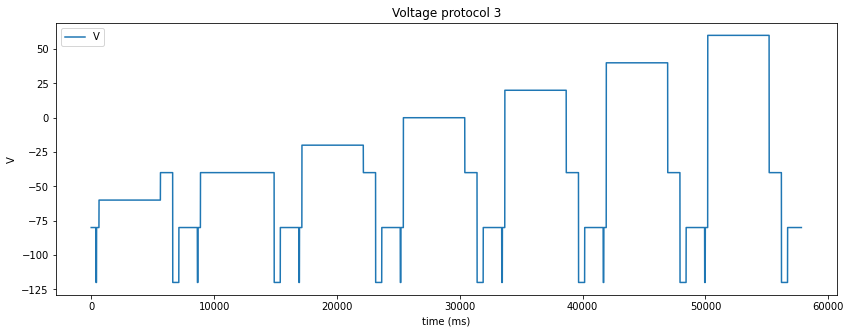

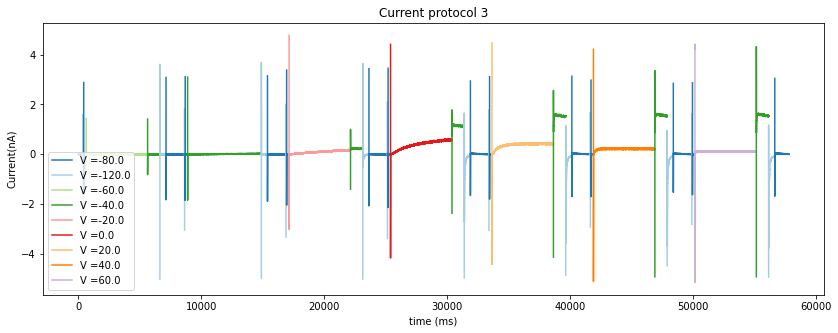

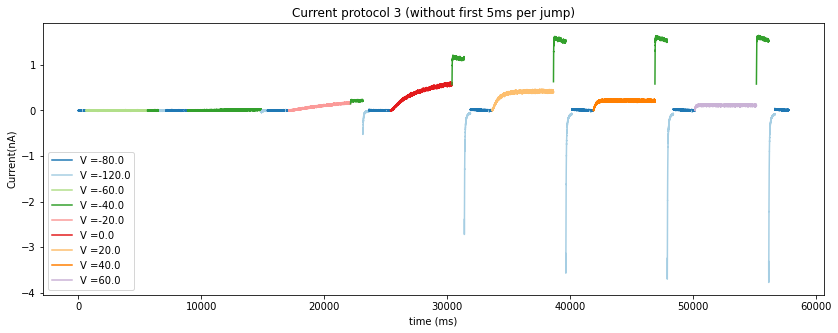

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(pr3_time, pr3_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()



## Estimate epsilon from V = -80

- load data for V=-80
- take residuals ? 
    - does it makes sense or is it directly take values since the mean current is zero?
- Get R^2 by batch and mean
- Get the mean of the R^2

15


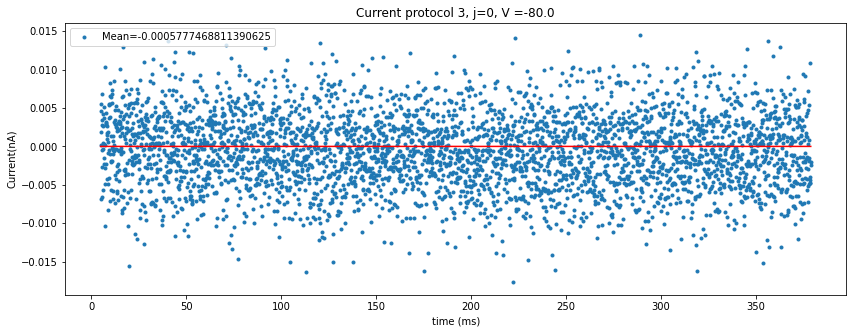

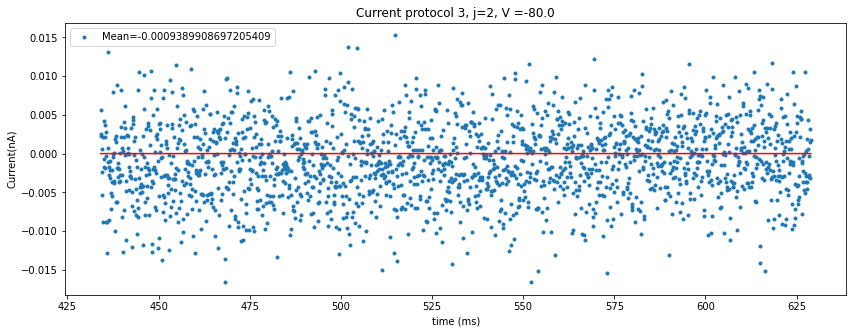

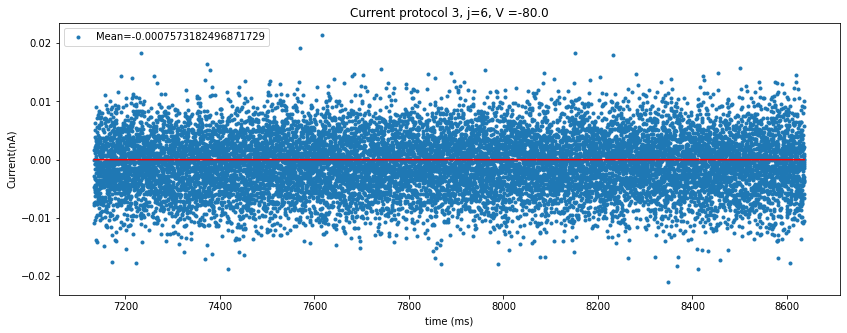

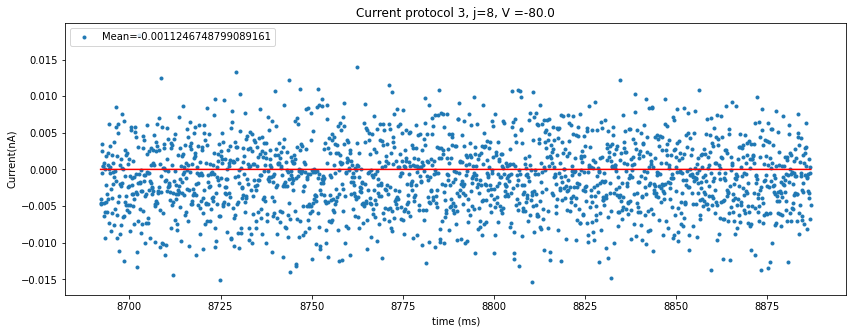

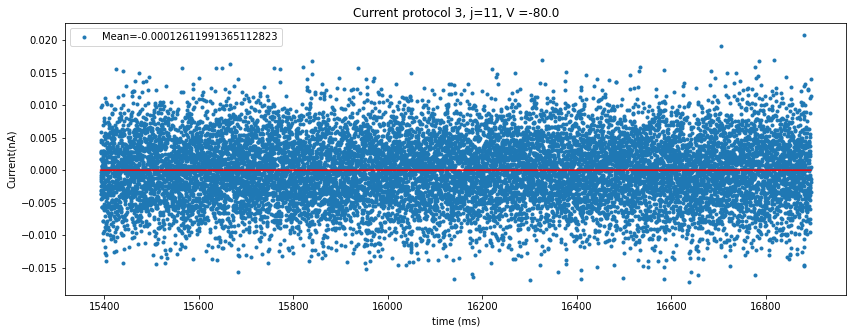

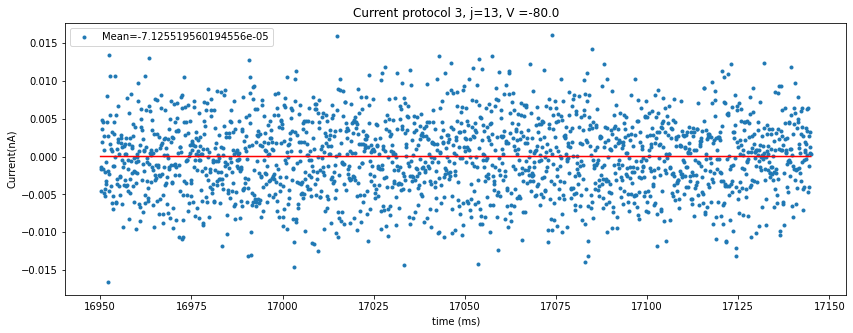

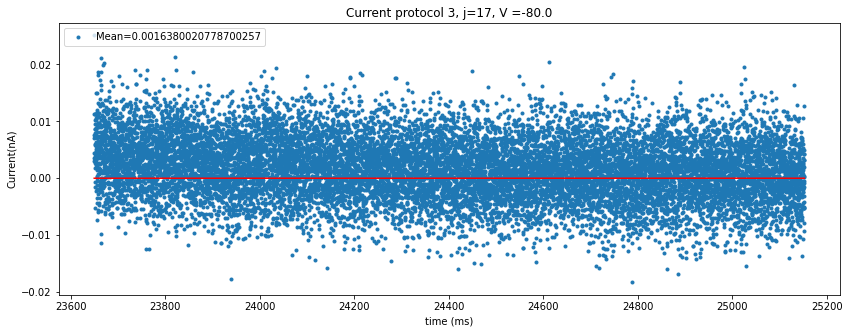

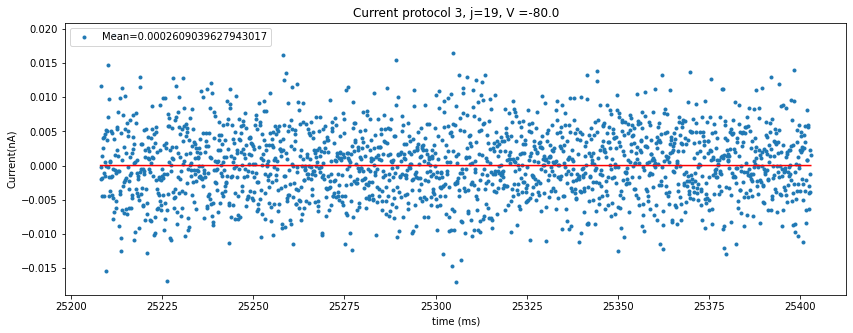

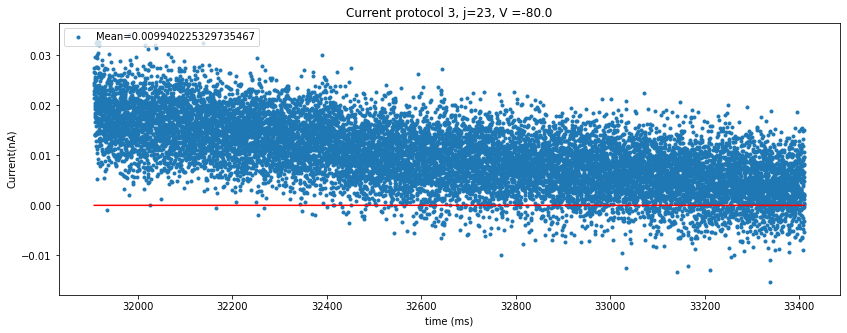

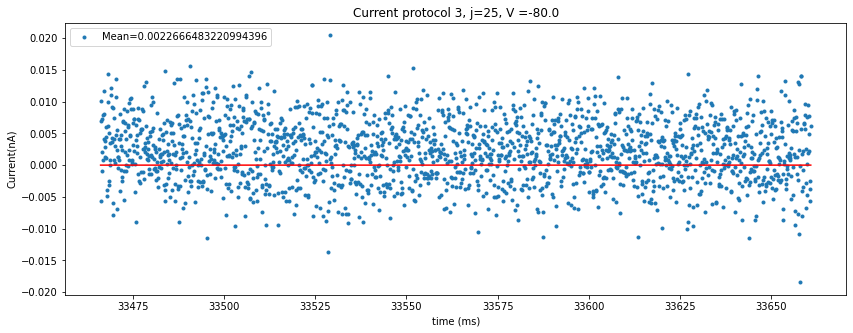

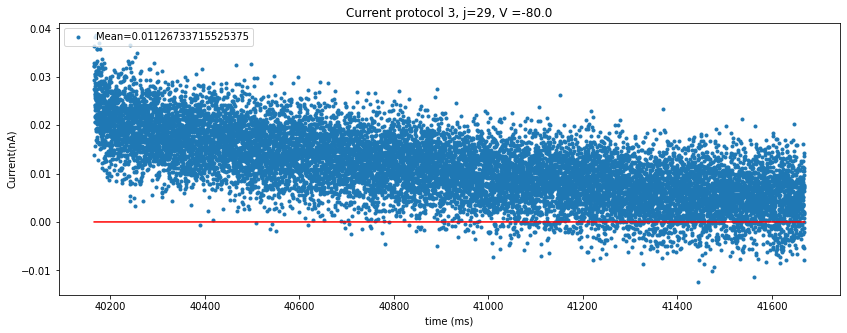

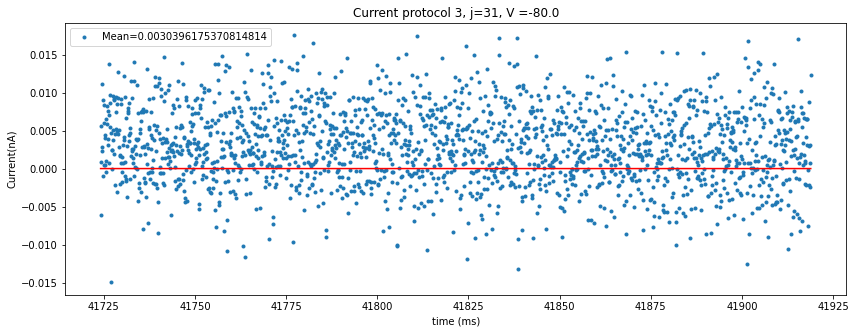

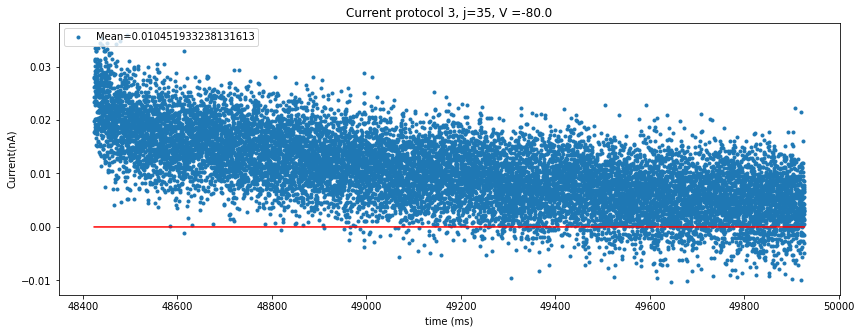

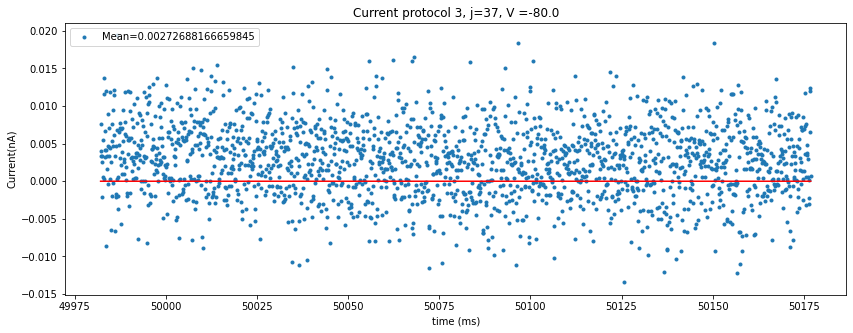

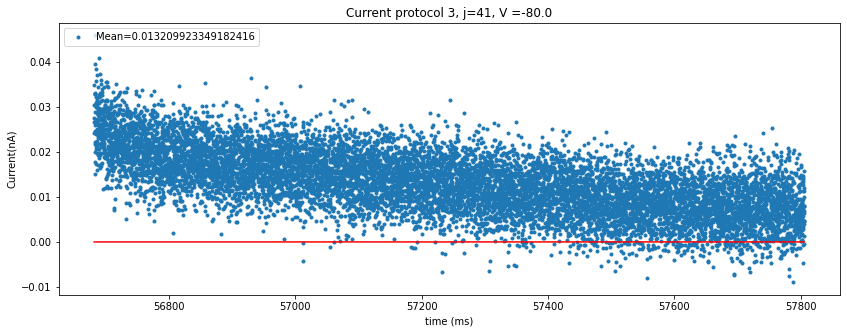

In [108]:
# Find where V = -80
print(sum(pr3_voltage_constV==-80))
index_neg80 = np.nonzero(pr3_voltage_constV==-80)
index_neg80 = index_neg80[0]
index_neg80_meanzero = []
V80_means = np.zeros(len(index_neg80))
V80_vars = np.zeros(len(index_neg80))

#pr3_current_constV_all80s =np.array([])
pr3_current_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_means[k] = np.mean(pr3_current_constV_without_first5ms[j])
    V80_vars[k] = np.var(pr3_current_constV_without_first5ms[j])
    #pr3_current_constV_all80s = np.append(pr3_current_constV_all80s, pr3_current_constV[j][times_to_skip:])
    if np.abs(V80_means[k]) < 0.009:
        index_neg80_meanzero.append(j)
        pr3_current_constV_80smeanzero =np.append(pr3_current_constV_80smeanzero, pr3_current_constV_without_first5ms[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j],'.', color = pr3_voltage_constV_colors[j], label='Mean='+str(np.mean(pr3_current_constV_without_first5ms[j])))
    plt.plot(pr3_time_constV_without_first5ms[j],np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


In [110]:
#print(V80_means)
#print(V80_vars)
print('---- ALL V=-80 -------- V=-80 AND |mean|<0.009---')
print('Mean of means by jump:')
print([np.mean(V80_means), np.mean(V80_means[np.abs(V80_means)<0.009])])
print('Mean of all the time steps together for mean<0.009:')
print([0, np.mean(pr3_current_constV_80smeanzero)])


print('Mean of Vars per jump:')
#print(V80_vars[np.abs(V80_means)<0.009])
epsilonA = np.mean(V80_vars)
epsilonB = np.mean(V80_vars[np.abs(V80_means)<0.002])
print([epsilonA, epsilonB])


print('Var of the time steps together: for mean<0.009:')
epsilon1 = np.var(pr3_current_constV_80smeanzero)
print([0, epsilon1])



---- ALL V=-80 -------- V=-80 AND |mean|<0.009---
Mean of means by jump:
[0.0034136911099358785, 0.0005759952342486302]
Mean of all the time steps together for mean<0.009:
[0, 0.0003391021796864299]
Mean of Vars per jump:
[3.0527468270471126e-05, 2.4921364042559807e-05]
Var of the time steps together: for mean<0.009:
[0, 2.702548900276314e-05]


# Leak current

I'll check the transition between V=-80 to V=-120 to check if the leak current has been removed from the data set. 

For protocol 3, we always have the sequence of Vs: 40, -120, -80, -120, -80. And I'm interested in the -80,-120, -80 part. 

[ 0  2  6  8 11 13 17 19 23 25 29 31 35 37]
[ 0  6 11 17 23 29 35]


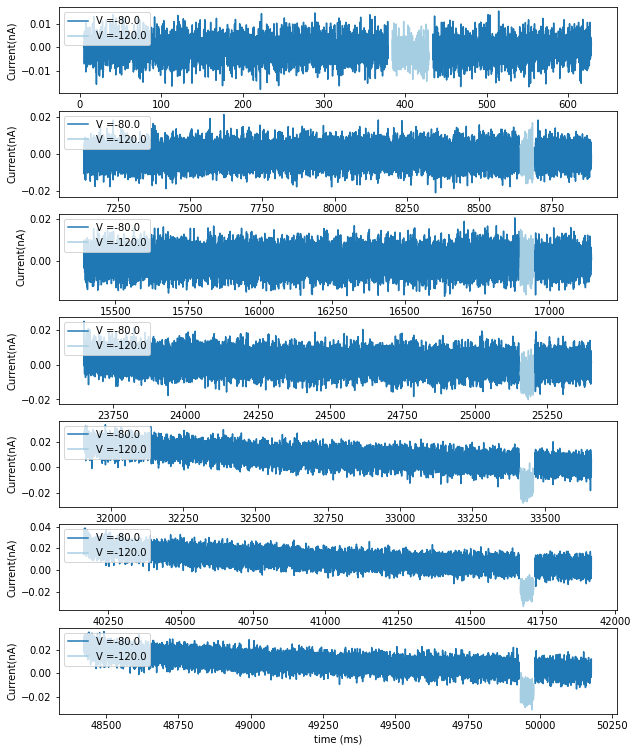

In [15]:

index_leak80 = np.nonzero(pr3_voltage_constV[:-2]==-80)
index_leak80 = index_leak80[0]
index_leak120 = np.nonzero(pr3_voltage_constV[index_leak80+1]==-120)
index_leak120 = index_leak120[0]
print(index_leak80)
print(index_leak80[index_leak120])

index_leak = index_leak80[index_leak120] # Index for the -80 to start the -80,-120,-80 jump. 


fig, axs = plt.subplots(len(index_leak),1, figsize=(10, 13))
axs = axs.ravel()

for k in range(len(index_leak)):
    j = index_leak[k]
    
    axs[k].plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j], color = pr3_voltage_constV_colors[j], label=pr3_voltage_constV_labels_full[j])
    axs[k].plot(pr3_time_constV_without_first5ms[j+1], pr3_current_constV_without_first5ms[j+1], color = pr3_voltage_constV_colors[j+1], label=pr3_voltage_constV_labels_full[j+1])
    axs[k].plot(pr3_time_constV_without_first5ms[j+2], pr3_current_constV_without_first5ms[j+2], color = pr3_voltage_constV_colors[j+2], label='_nolegend_')
    axs[k].set_ylabel('Current(nA)')
    axs[k].legend(loc='upper left')
axs[k].set_xlabel('time (ms)')

plt.show()

## Voltage larger or equal than -40


In [16]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

splines_largerCurrents = [None] * len(index_largerCurrents)
splines_params_largerCurrents = [None] * len(index_largerCurrents)
residuals2_largerCurrents = [None] * len(index_largerCurrents)
times_largerCurrents = [None] * len(index_largerCurrents)
currents_largerCurrents = [None] * len(index_largerCurrents)
deltat_largerCurrents = np.zeros(len(index_largerCurrents))


splines_largerCurrents_weights = [None] * len(index_largerCurrents)
splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)
residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    currents_largerCurrents[index_i] = pr3_current_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]


[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


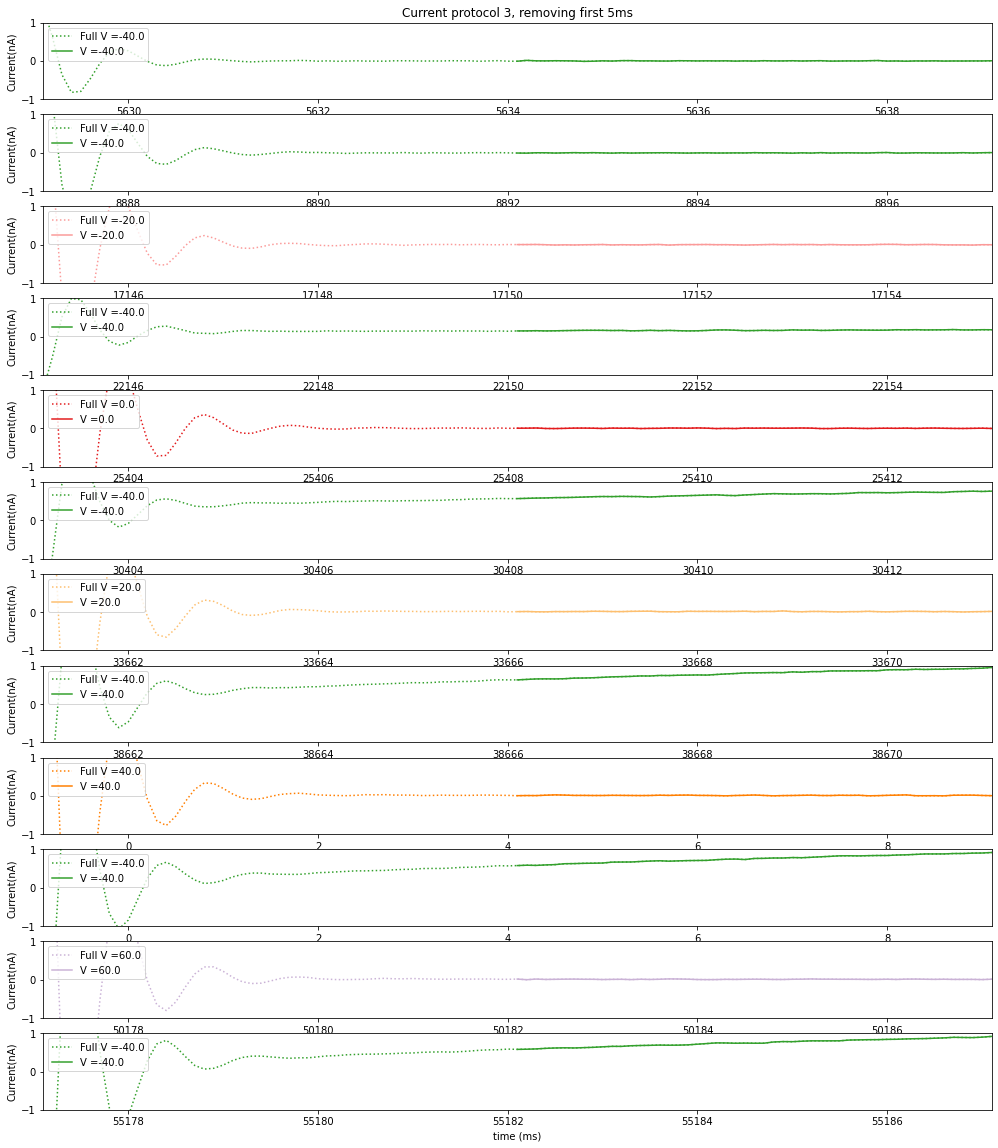

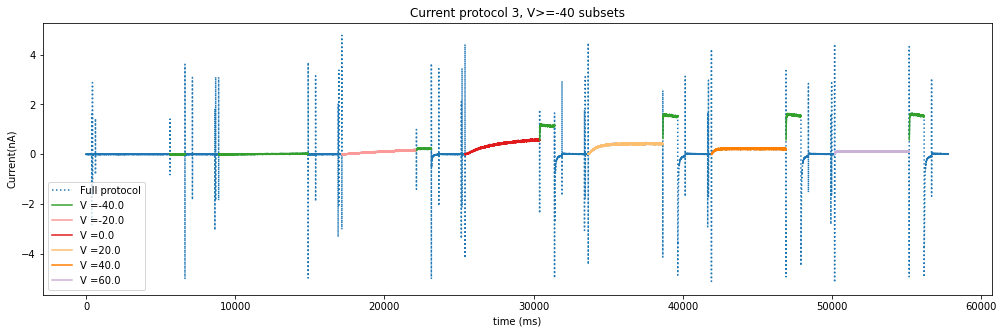

In [17]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()


In [28]:
# We will use 4 exponentials

NumExpo_flag = True
saved_splines = True
if saved_splines:
    print('Next cell will load the splines parameters instead of fitting them')

Next cell will load the splines parameters instead of fitting them


In [29]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines:
    # Load the parameters of the spline:
    splines_params_largerCurrents = np.load('protocol3_cell2_splines_params_largerCurrents.npy')
    for index_i in range(len(index_largerCurrents)): 
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    print('Loading DONE')
else:
    # CMA fit, NO weights. If paramerers had been save, skip this cell
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents[index_i] = es[0]
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    # SAve the parameters of the spline:
    np.save('protocol3_cell2_splines_params_largerCurrents.npy',np.array(splines_params_largerCurrents))
    print('Fitting DONE')



Loading DONE


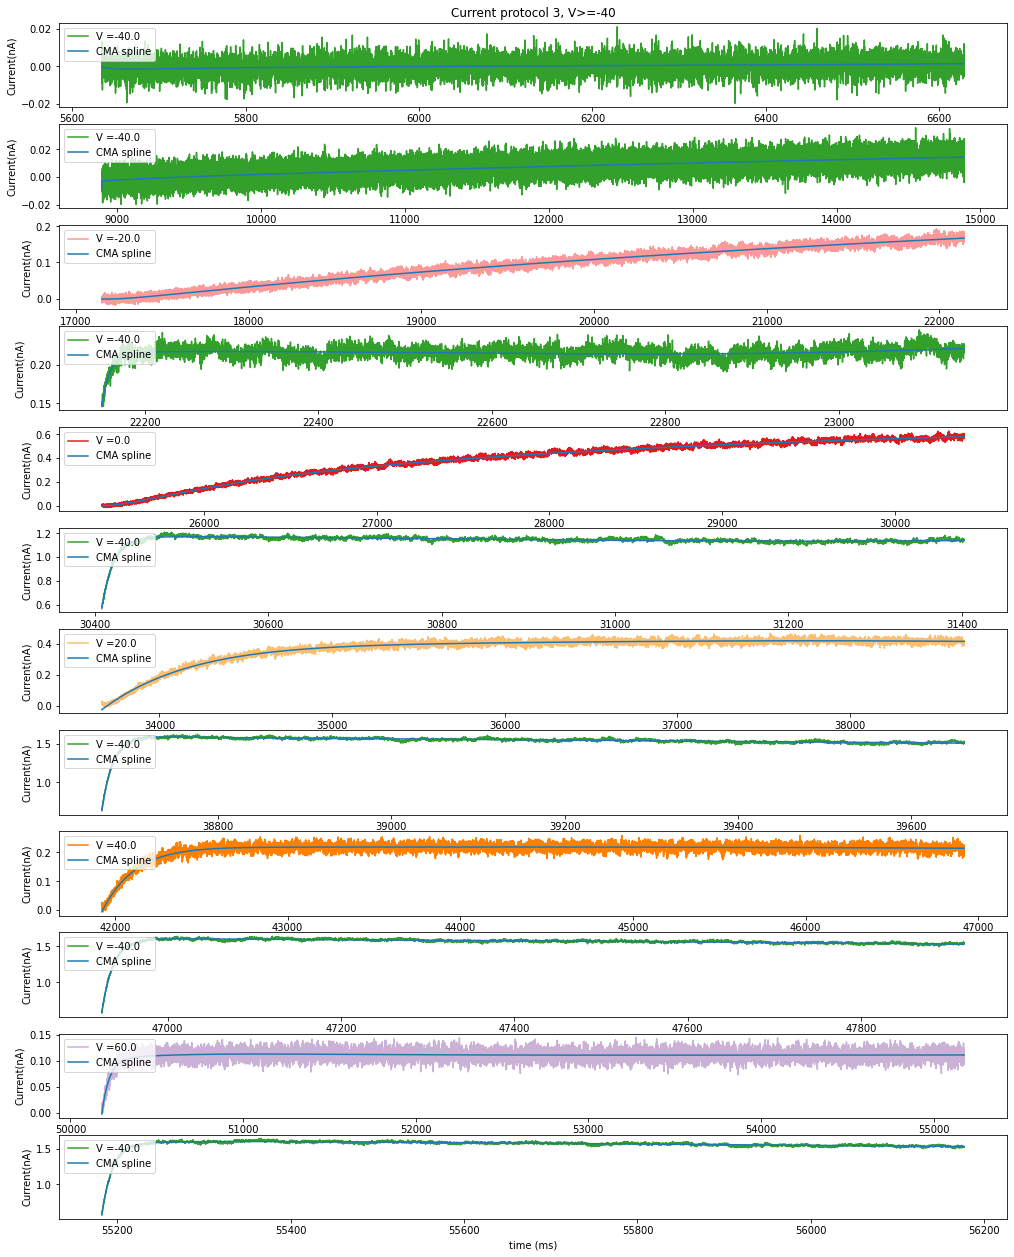

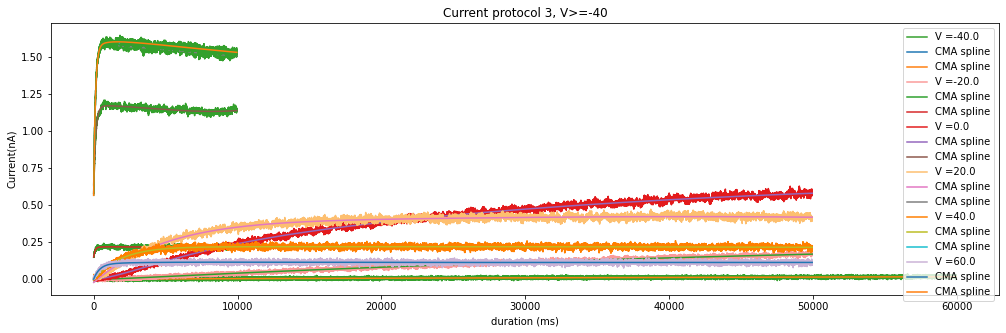

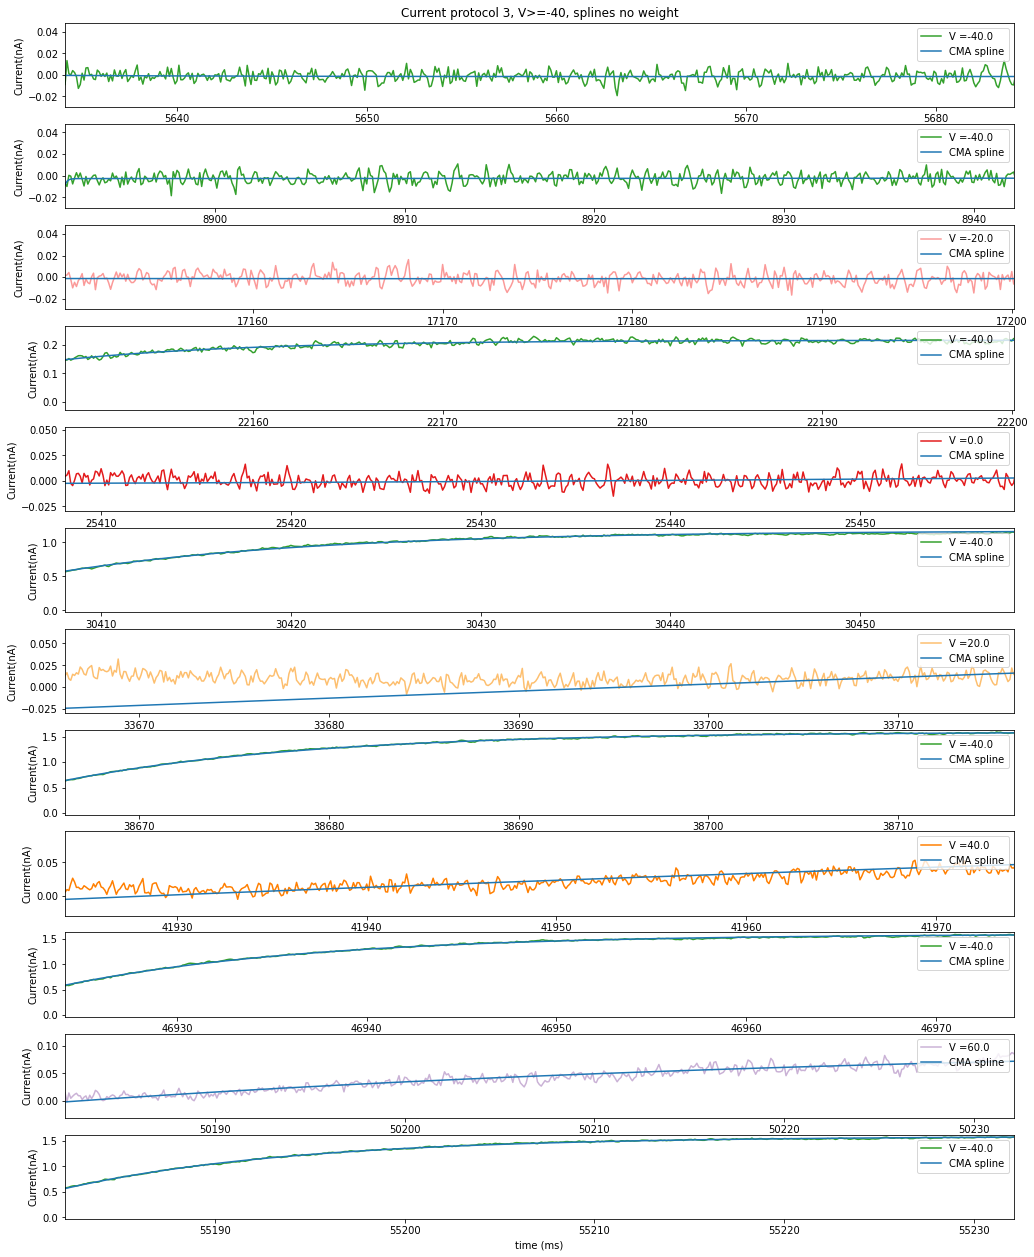

In [30]:
# Trying a better plot
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper right')
plt.show()

# Zoom with no weights

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0],times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, splines no weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

In [31]:
# Find or load the splines parameters. WITH WEIGHTS
if saved_splines:
    # Load the parameters
    splines_params_largerCurrents_weights = np.load('protocol3_cell2_splines_params_largerCurrents_weights.npy')
    for index_i in range(len(index_largerCurrents)): 
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA_fit with weighting residuals
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents_weights[index_i] = es[0]
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save('protocol3_cell2_splines_params_largerCurrents_weights.npy',np.array(splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')


Loading with weights DONE


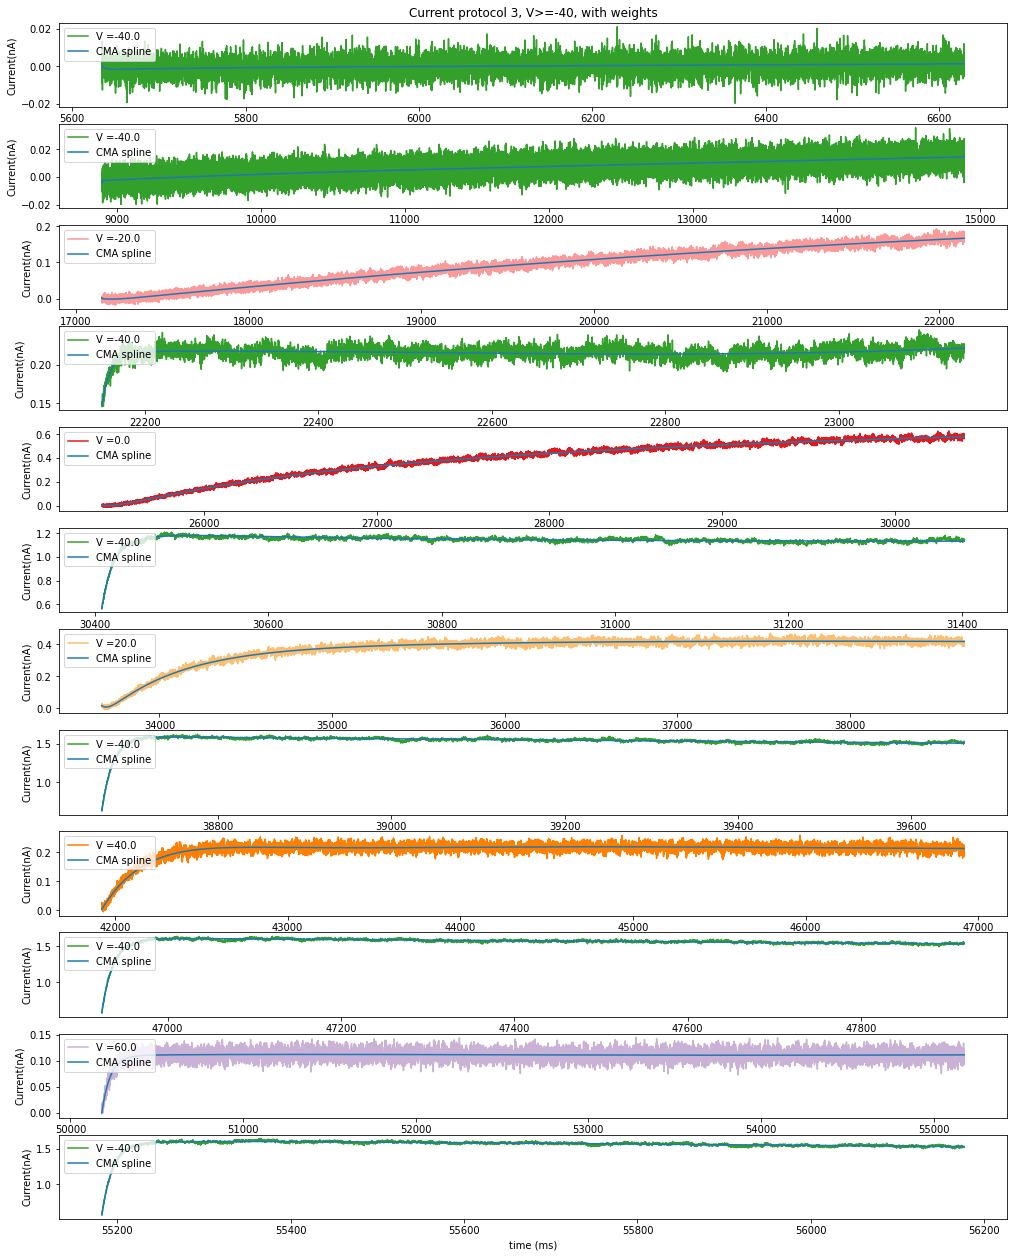

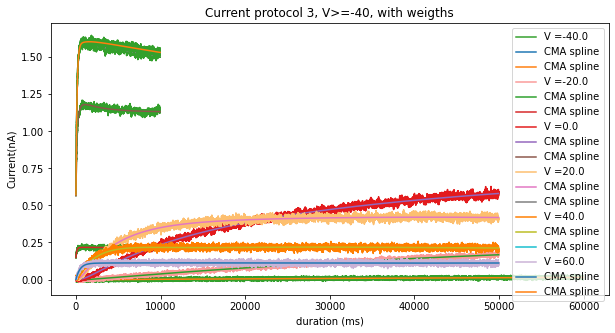

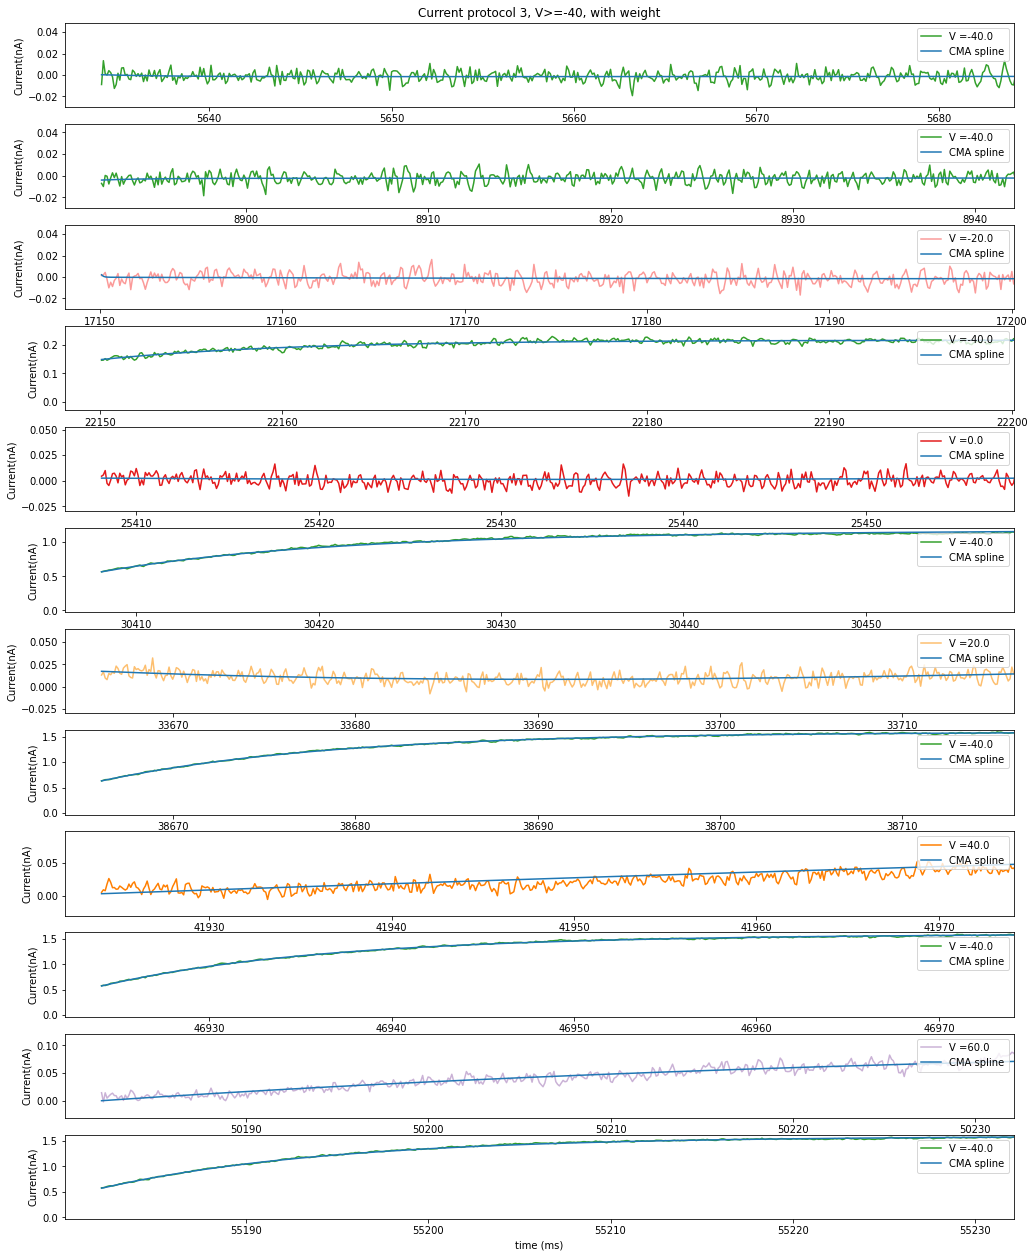

In [32]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents_weights[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()

# Zoom

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0]-2,times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents_weights[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

## Start analysis of the residuals (noise)

We will use the data with splines AND weights: "spline_..._weights"

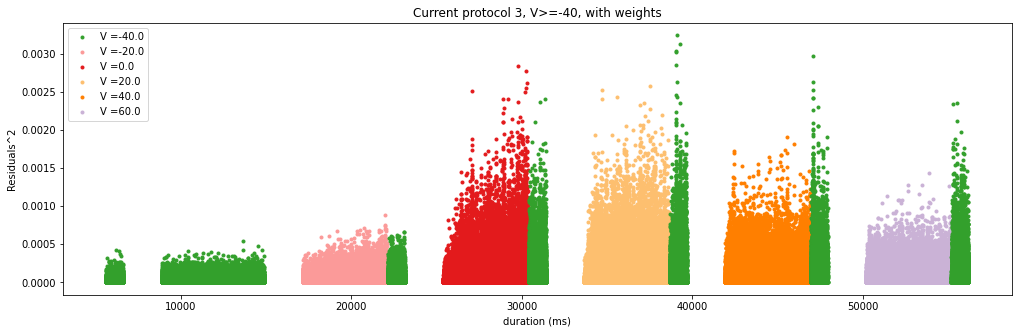

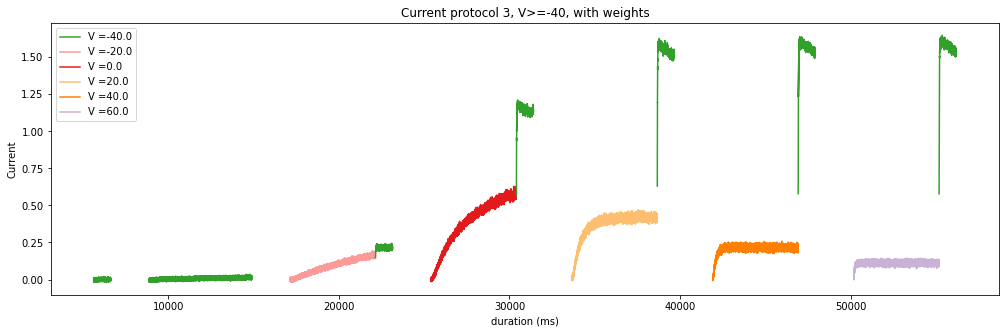

In [33]:
# Residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents_weights[index_i]
    residuals2_largerCurrents_weights[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Current')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

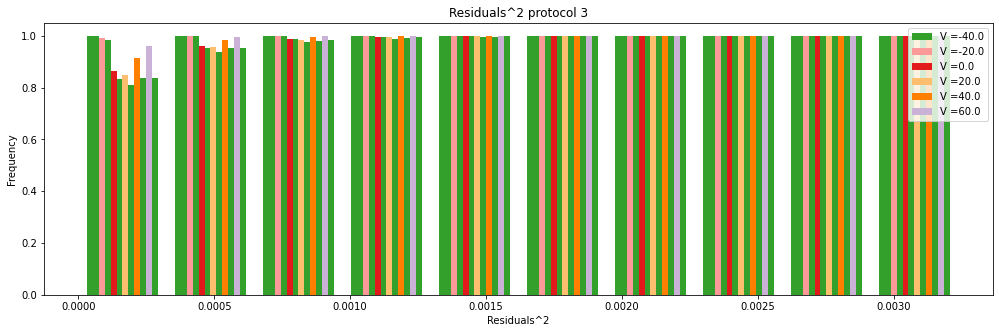

In [34]:
# Histograms of the residuasl
plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights, bins = 10, density =True, cumulative=True, color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.legend(loc='upper right')
plt.xlabel('Residuals^2')
plt.ylabel('Frequency')
plt.title('Residuals^2 protocol 3')

plt.show()

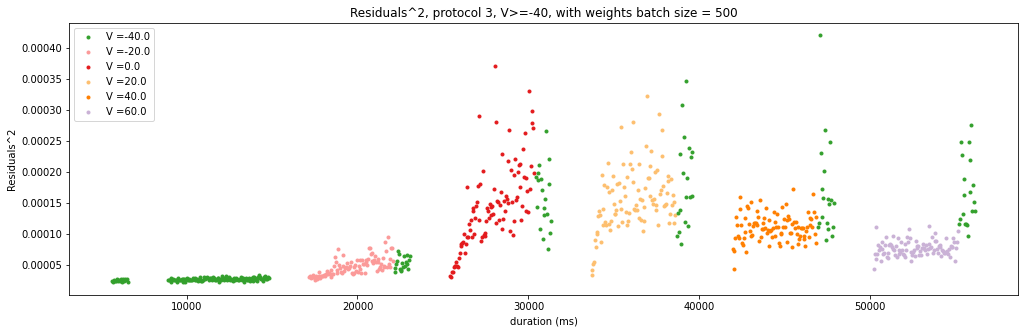

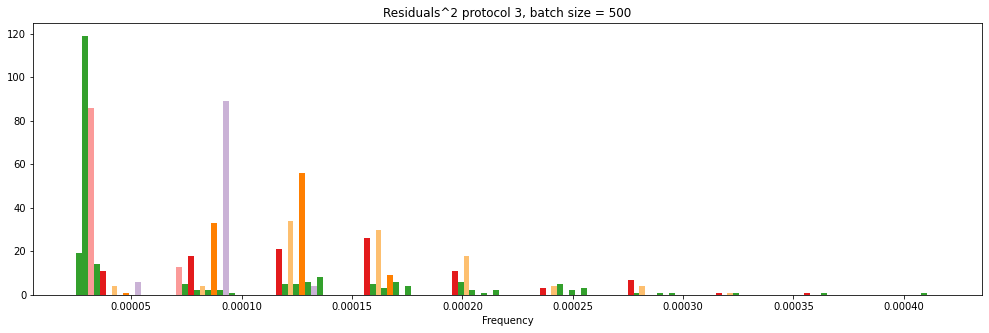

In [35]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 500
remove_at_end_weights = np.zeros(len(residuals2_largerCurrents_weights)).astype(int)
residuals2_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
times_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
splines_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
currents_largerCurrents_meanbatch = [None] * len(index_largerCurrents)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    remove_at_end_weights[index_i] = len(residuals2_largerCurrents_weights[index_i])%batch_size
    residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    times_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(times_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    currents_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(currents_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights_meanbatch,  color = np.array(pr3_voltage_constV_colors)[index_largerCurrents.astype(int)], label=pr3_voltage_constV_labels_simple[index_largerCurrents.astype(int)])
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, batch size = ' + str(batch_size))
plt.show()




## Scatter plots

Residuals vs: Voltage, Current, and opennes

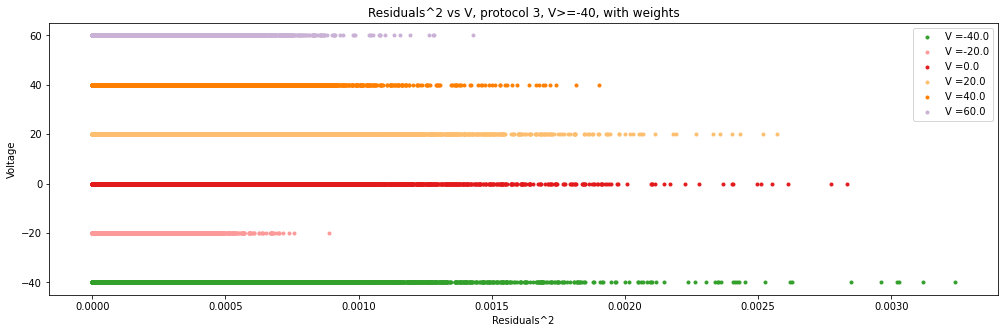

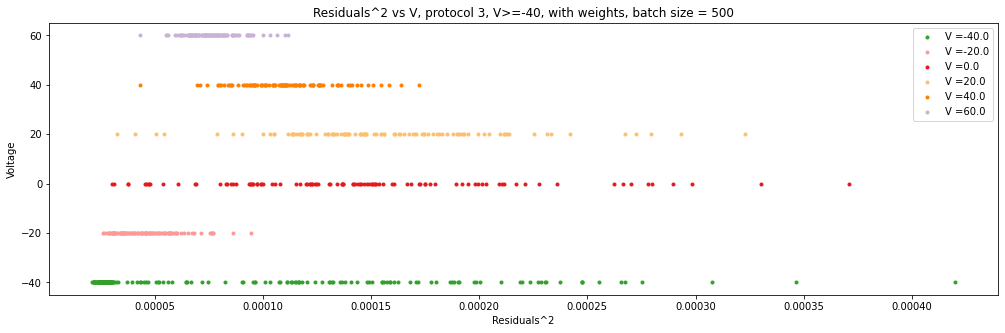

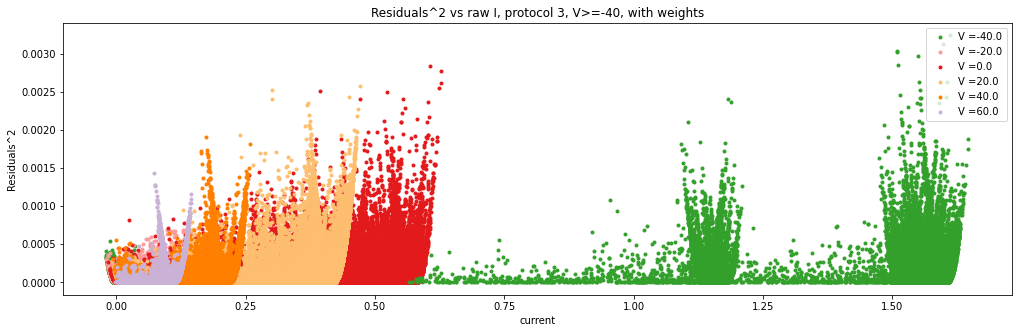

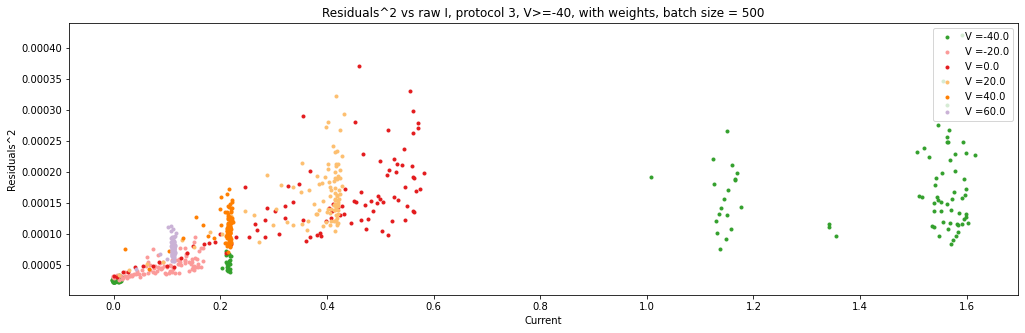

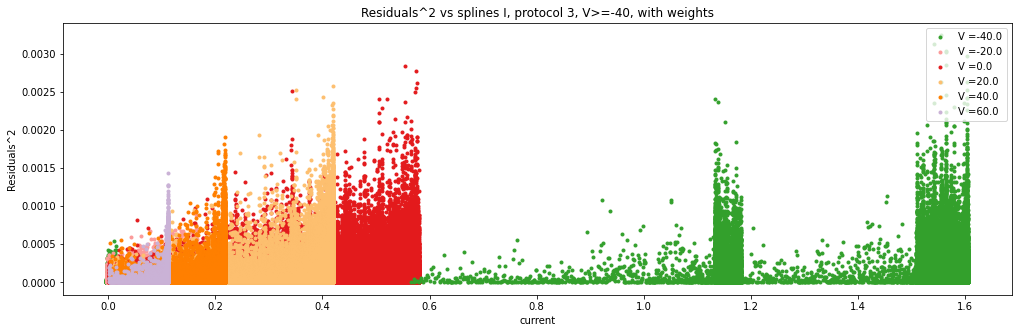

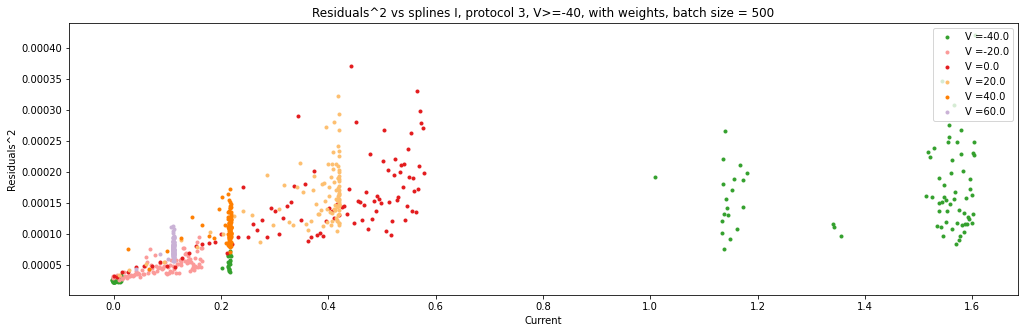

In [36]:

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot( residuals2_largerCurrents_weights[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights[index_i])),'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(residuals2_largerCurrents_weights_meanbatch[index_i], pr3_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights_meanbatch[index_i])), '.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Individual currents (o micro currents)

For micro current:
- Micro current will refer to the indivudual channel current
    - We can get it using i(V) = (V- Ek)*gamma_i
- gamma_i (where gamma_micro is the conductance of an individual channel)
- So the total cell current is I(V) = i(V) * N * O, which is the one we get from the experiments


The parameters:
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time


In [37]:
# Single channel parameters
N_upper = 76000
N_lower = 10000
Ek = -85
gamma_i = 2e-6# 2 pS -> to uS

# pr3_voltage_constV has the voltages at each step j
indv_current = (pr3_voltage_constV - Ek)*gamma_i 

print(pr3_voltage_constV)
print(indv_current)

[ -80. -120.  -80.  -60.  -40. -120.  -80. -120.  -80.  -40. -120.  -80.
 -120.  -80.  -20.  -40. -120.  -80. -120.  -80.    0.  -40. -120.  -80.
 -120.  -80.   20.  -40. -120.  -80. -120.  -80.   40.  -40. -120.  -80.
 -120.  -80.   60.  -40. -120.  -80.]
[ 1.0e-05 -7.0e-05  1.0e-05  5.0e-05  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05
  1.0e-05  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  1.3e-04  9.0e-05
 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  1.7e-04  9.0e-05 -7.0e-05  1.0e-05
 -7.0e-05  1.0e-05  2.1e-04  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05
  2.5e-04  9.0e-05 -7.0e-05  1.0e-05 -7.0e-05  1.0e-05  2.9e-04  9.0e-05
 -7.0e-05  1.0e-05]


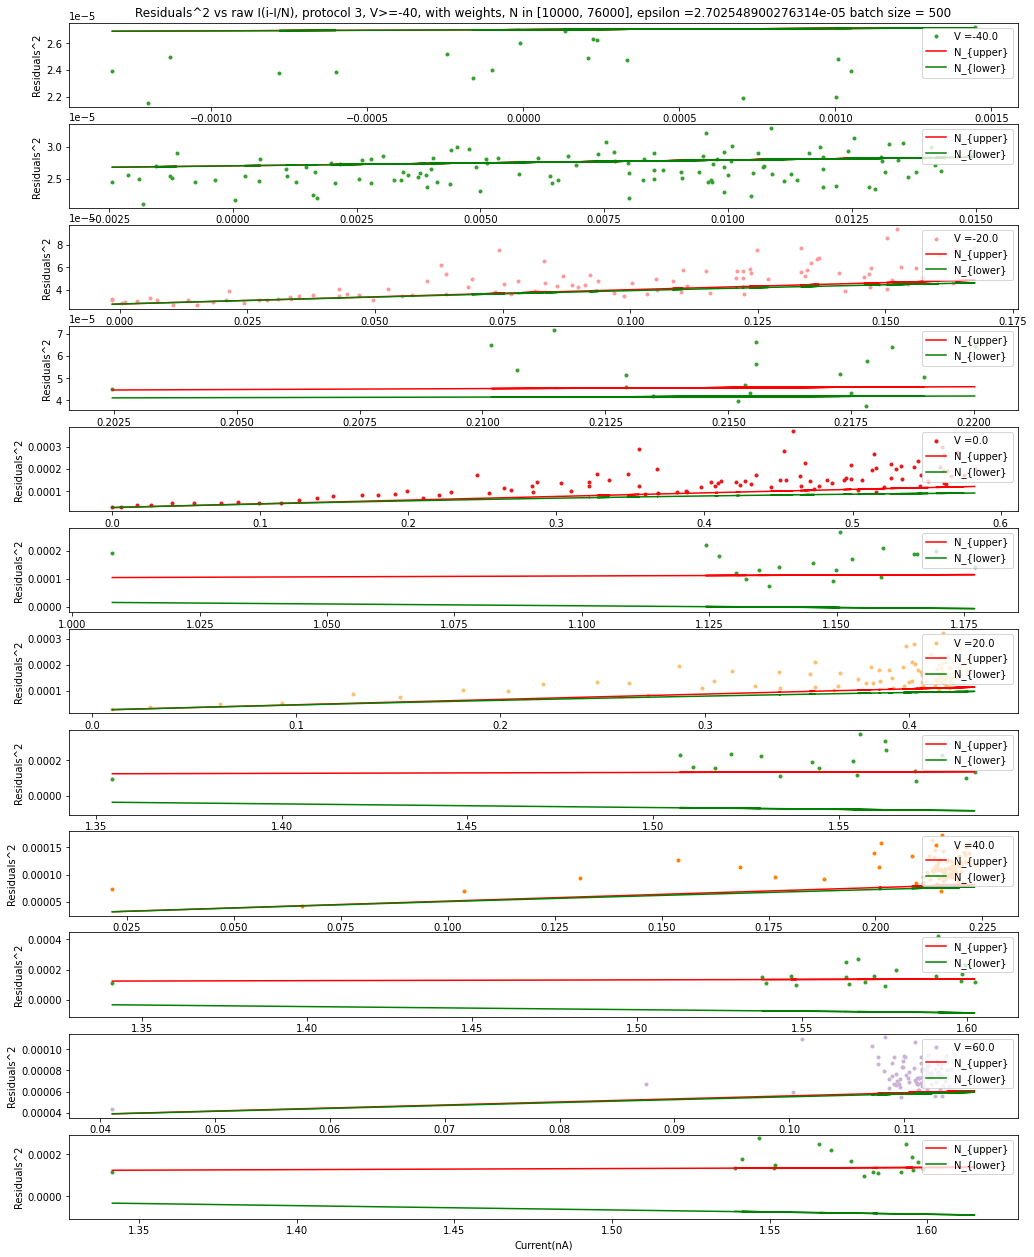

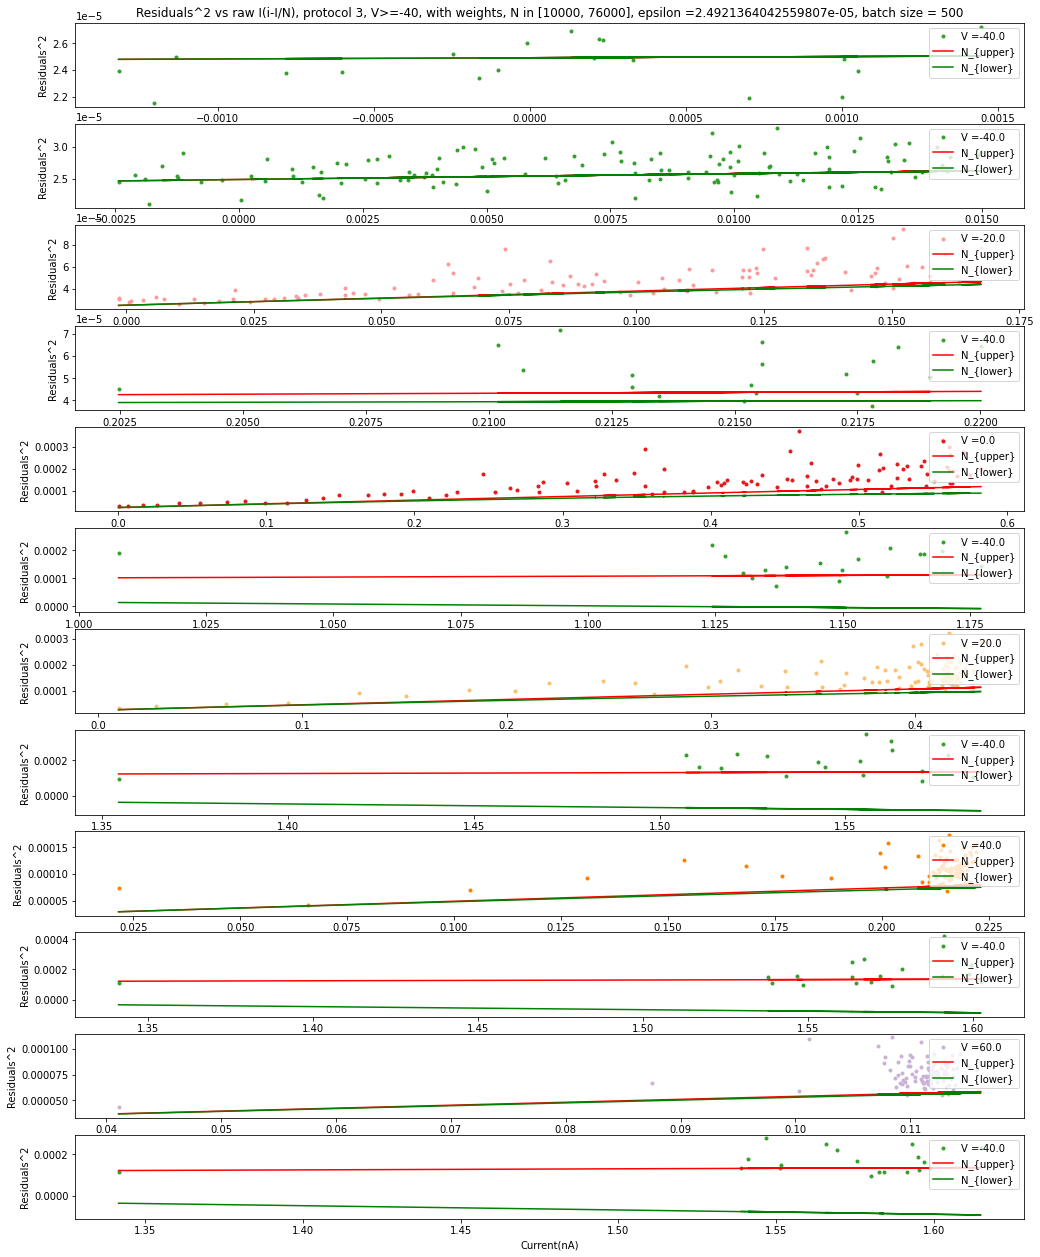

In [40]:
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilon1)+' batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()



fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilonB)+', batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()

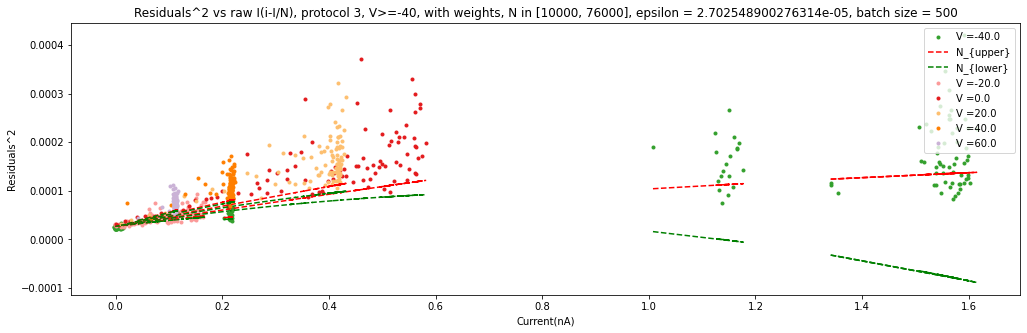

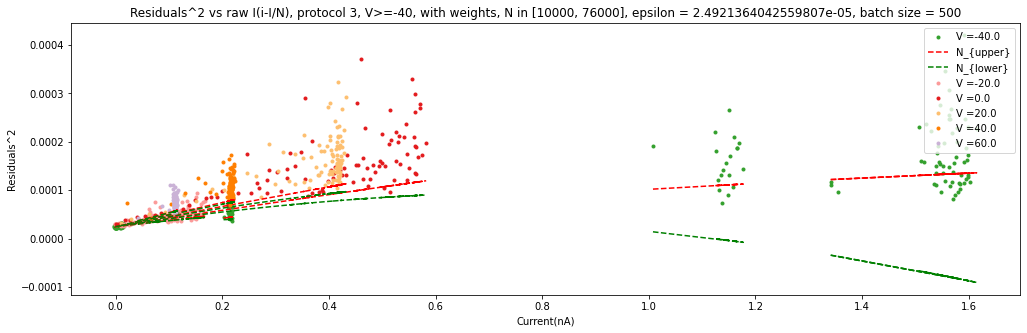

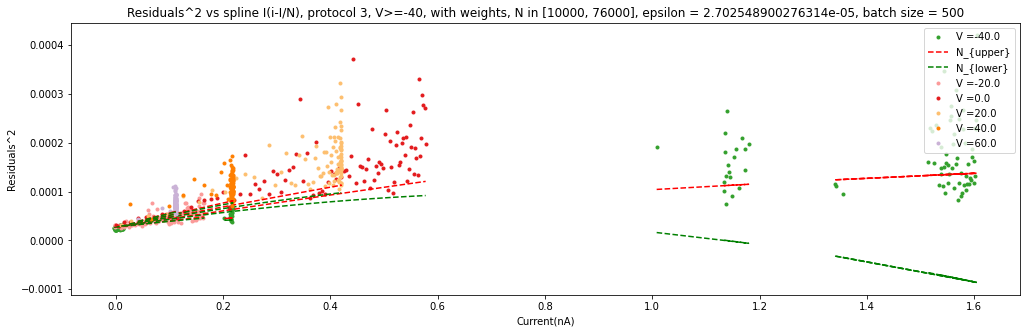

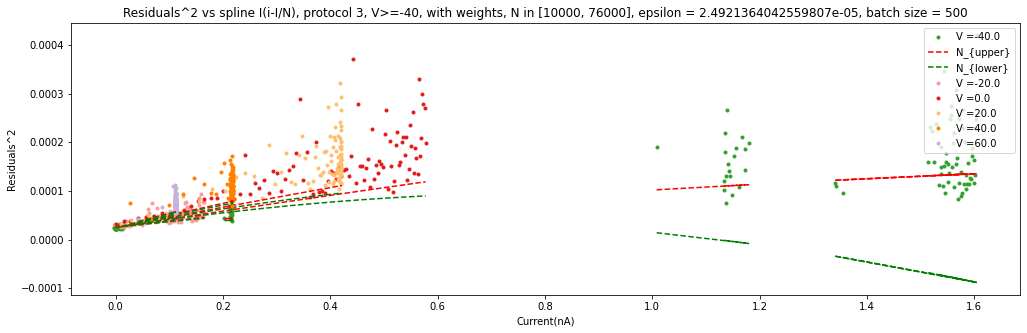

In [46]:
plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()




plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()

## Just to double check: linear regresion:

coefficient of determination: 0.07586326991465797
intercept: 2.4487662484293502e-05
slope: [0.00061329]
individual current =  9.999999999999999e-06


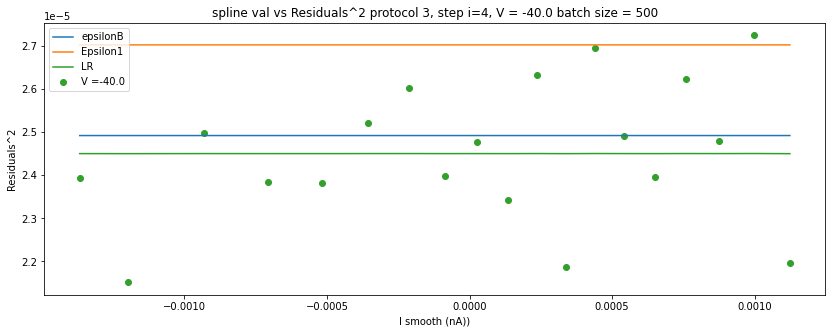

In [57]:
x =  splines_largerCurrents_weights_meanbatch[0].reshape(-1,1)
y = residuals2_largerCurrents_weights_meanbatch[0]
model_LR = LinearRegression()
model_LR.fit(x, y)
r_sq = model_LR.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)

print('individual current = ', indv_current[0])


plt.figure(figsize=(14, 5))
plt.scatter(x, y, color = pr3_voltage_constV_colors[index_largerCurrents[0]], label=pr3_voltage_constV_labels_simple[index_largerCurrents[0]])
plt.plot(x, epsilonB + y * (indv_current[0] - y/N_upper), label = 'epsilonB')
plt.plot(x, epsilon1 + y * (indv_current[0] - y/N_upper), label = 'Epsilon1')
plt.plot(x, model_LR.intercept_ + y * model_LR.coef_, label = 'LR')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(index_largerCurrents[0]) + ', V = '+ str(pr3_voltage[pr3_Vtimes[index_largerCurrents[0]]])+ ' batch size = ' + str(batch_size))


plt.show()

## Openesss

STILL WORK IN PROGRES!!!


For opennes:
- Open is I(V) = N * p_o * (V- Ek)*gamma_i = N * O * i(V), so 
    - O = I(V) / ( i(V))

The parameters: (same as for individual currents)
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time

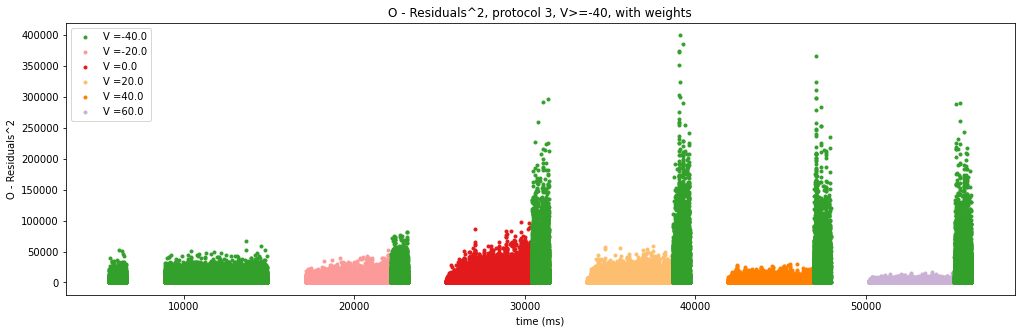

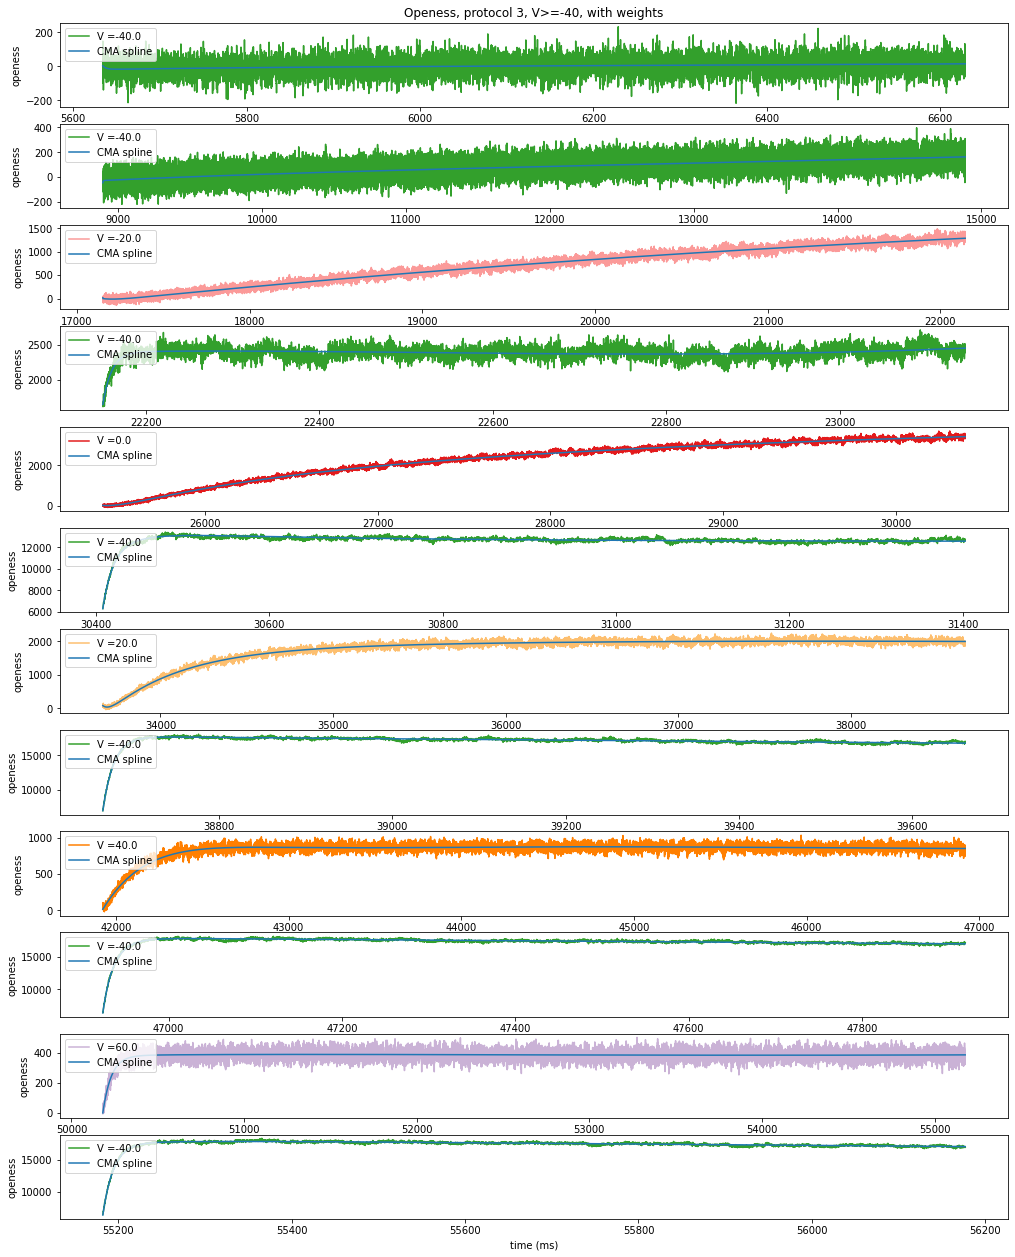

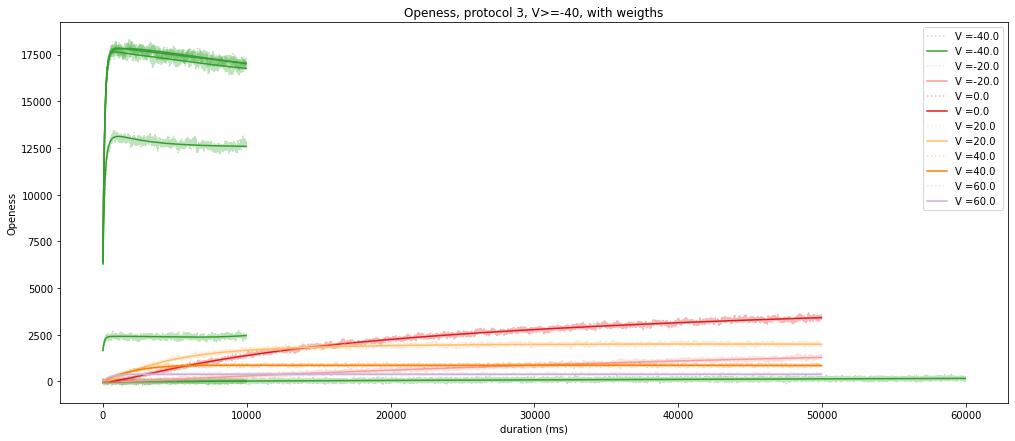

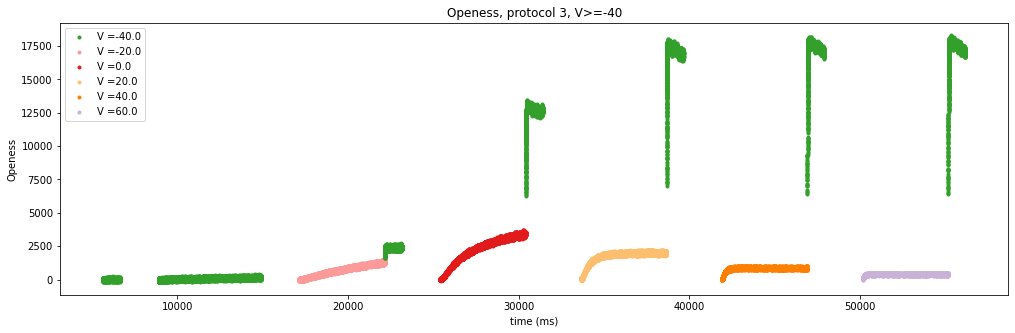

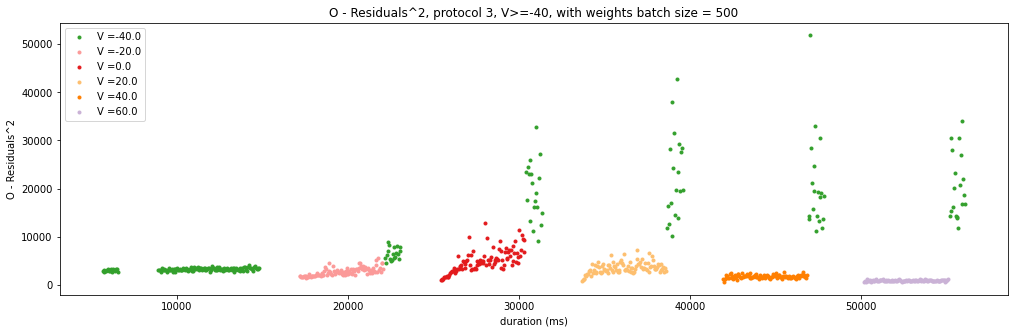

In [73]:
# Raw data
open_largerCurrents = [None] * len(index_largerCurrents)
open_splines_largerCurrents_weights = [None] * len(index_largerCurrents)
open_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)
# batch data
open_largerCurrents_meanbatch = [None] * len(index_largerCurrents)
open_splines_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)
open_residuals2_largerCurrents_weights_meanbatch = [None] * len(index_largerCurrents)

# Calculate the raw openes, the equivalent spline data and the residuals2

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    # Directly from the formula O = I/(N*i)
    open_largerCurrents[index_i] = currents_largerCurrents[index_i] / ( indv_current[i])
    open_splines_largerCurrents_weights[index_i] = splines_largerCurrents_weights[index_i] / ( indv_current[i])
    residuals = open_largerCurrents[index_i] - open_splines_largerCurrents_weights[index_i]
    open_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    # Batch them
    open_residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(open_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('O - Residuals^2')
plt.title('O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()



fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], open_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('openess')
    if index_i == 0:
        axs[index_i].set_title('Openess, protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 7))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i],':', color = pr3_voltage_constV_colors[i],alpha = 0.3, label=pr3_voltage_constV_labels_simple[i])
    plt.plot(open_splines_largerCurrents_weights[index_i], color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Openess')
plt.title('Openess, protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Openess')
plt.title('Openess, protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('O - Residuals^2')
plt.title('O - Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


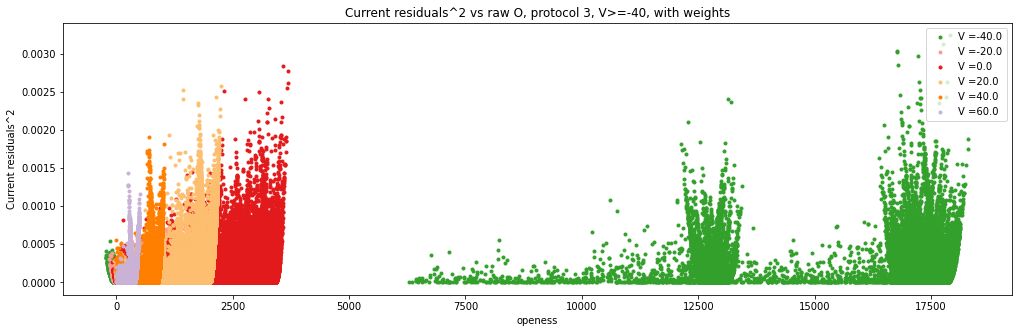

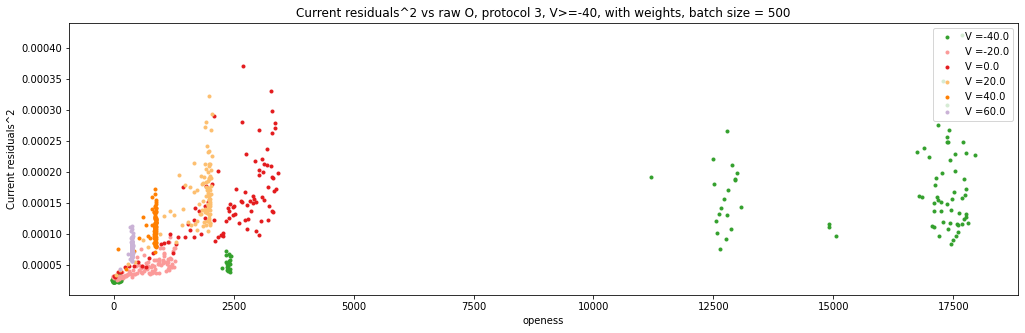

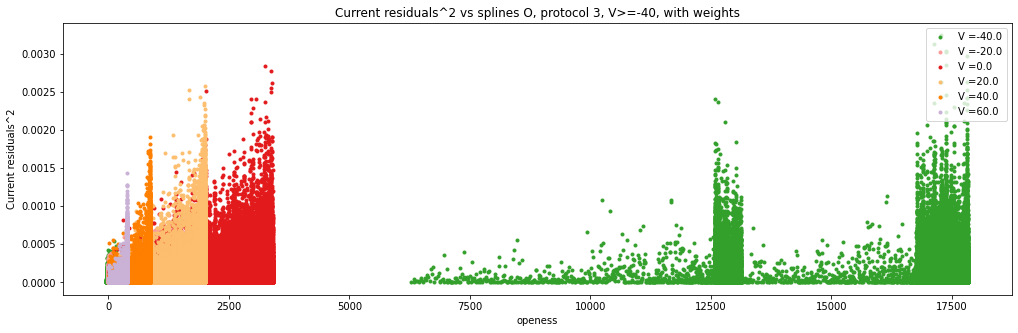

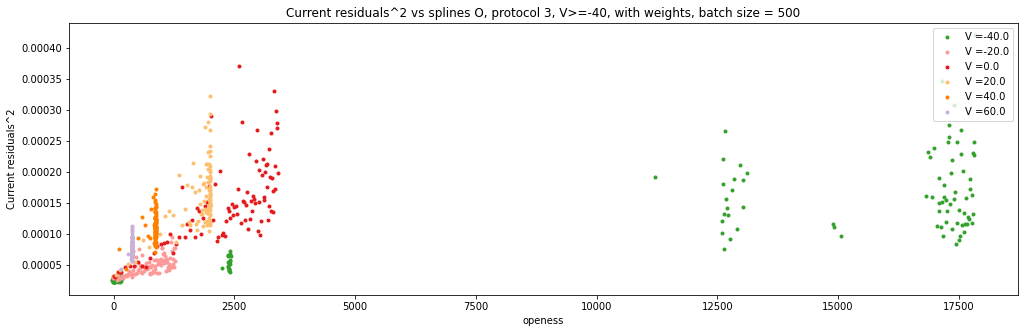

In [74]:
# Rest of the scatter plots comaring to CURRENT RESIDUASL

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

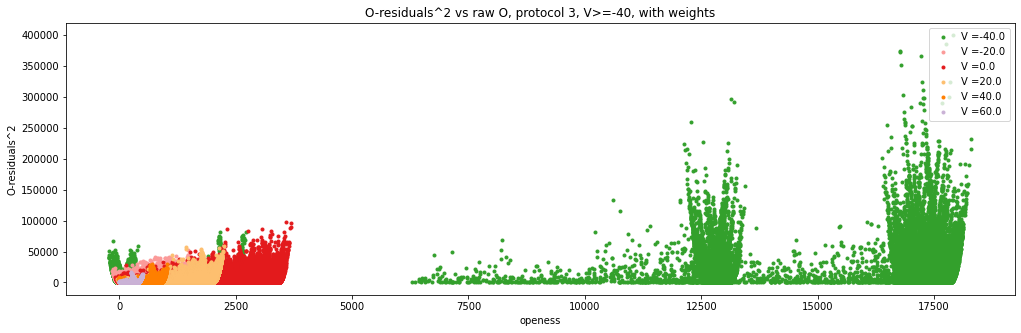

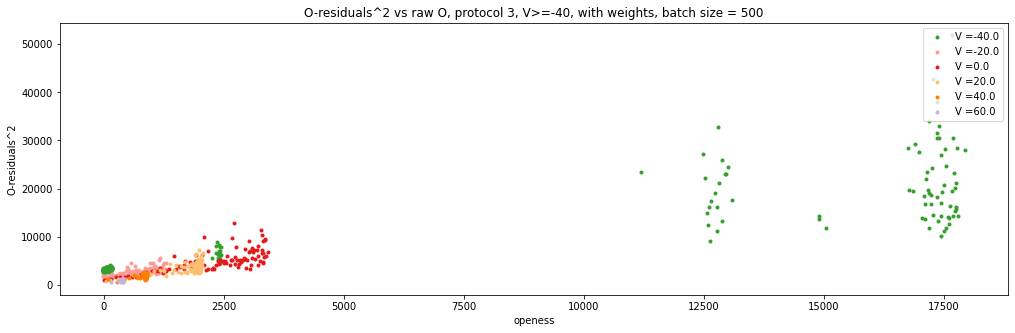

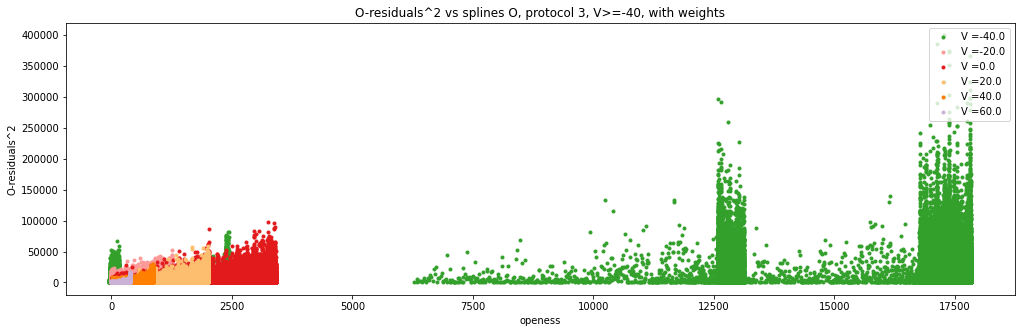

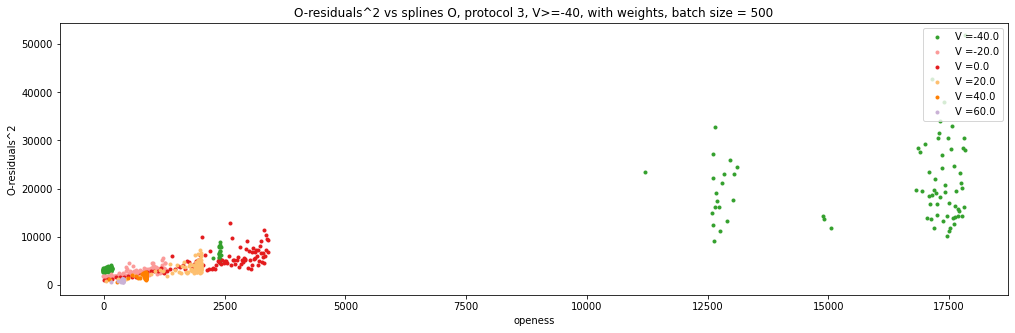

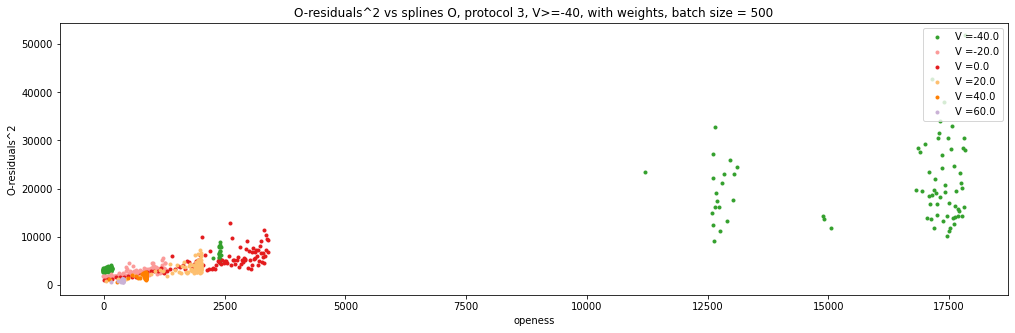

In [75]:
# Open vs open residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

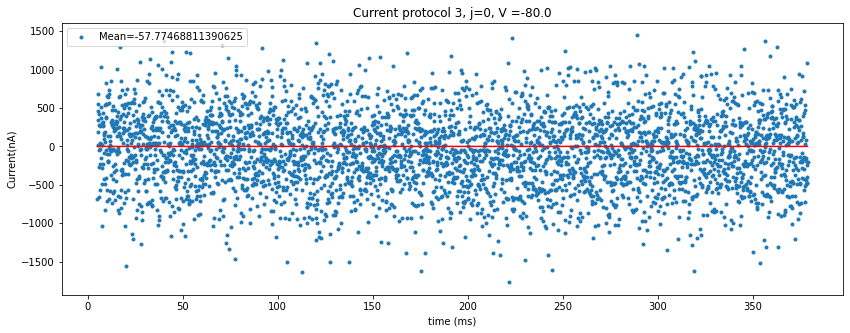

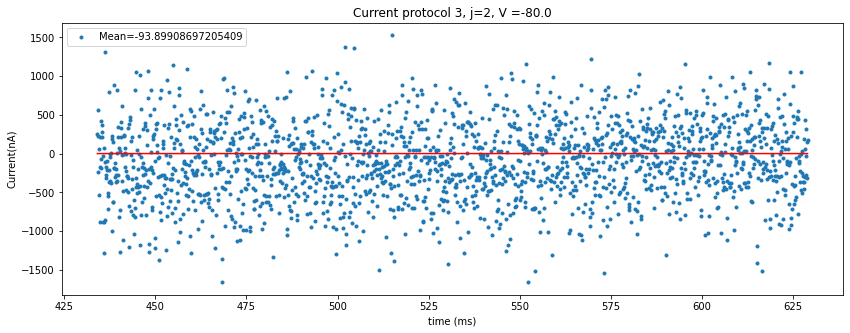

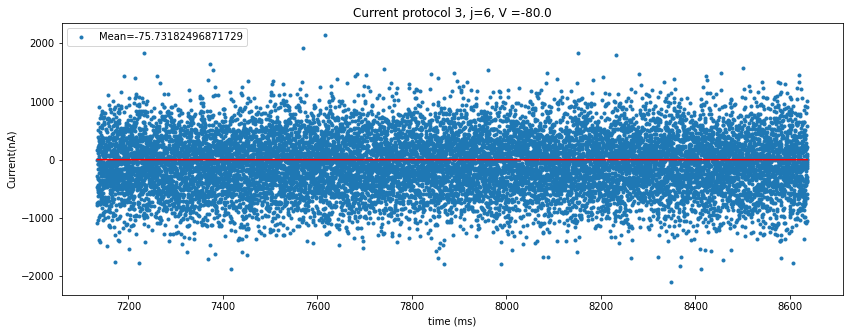

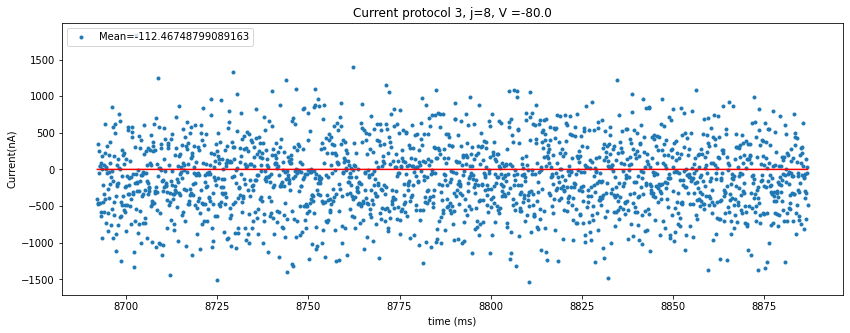

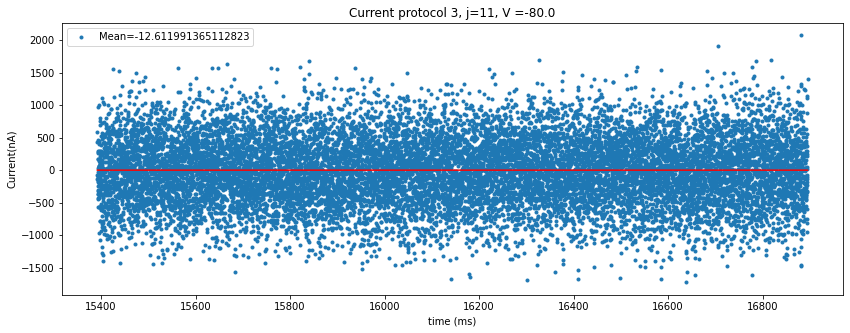

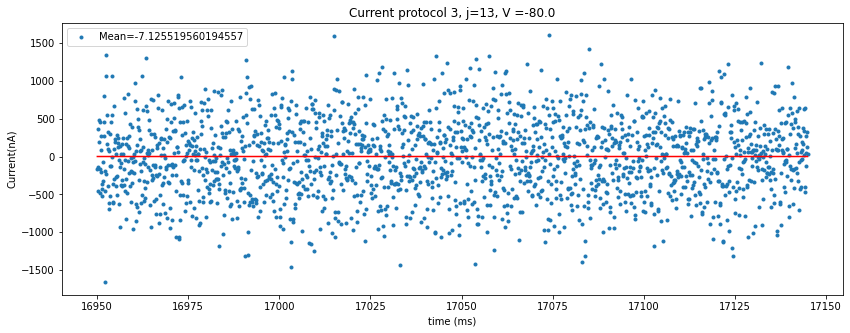

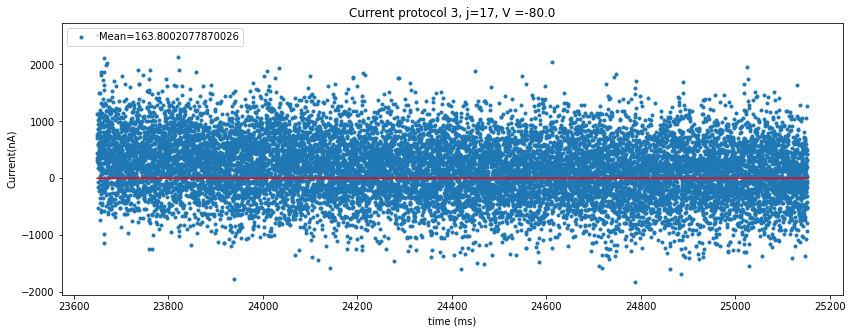

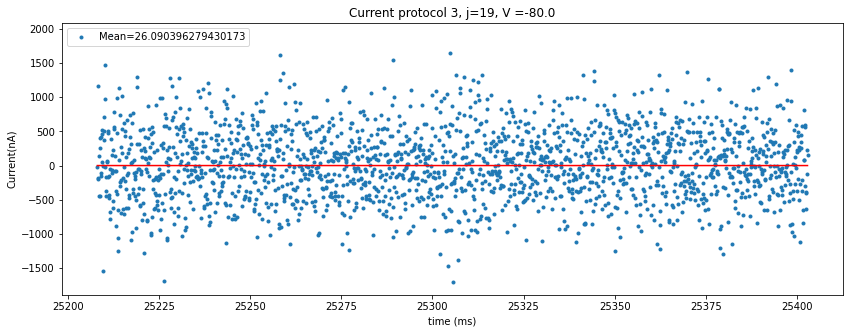

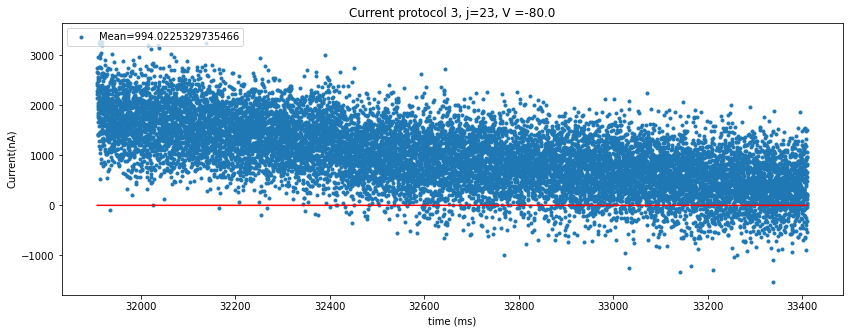

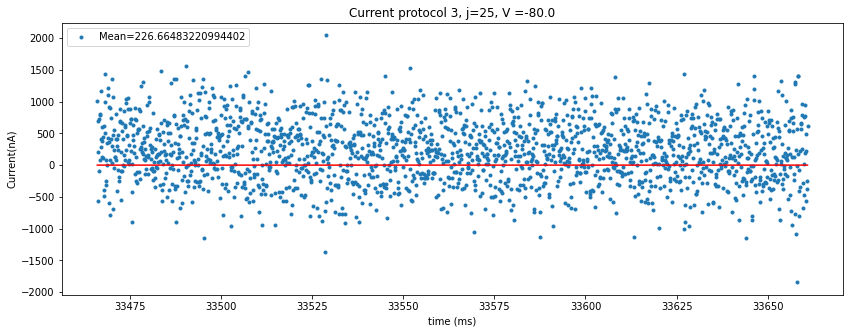

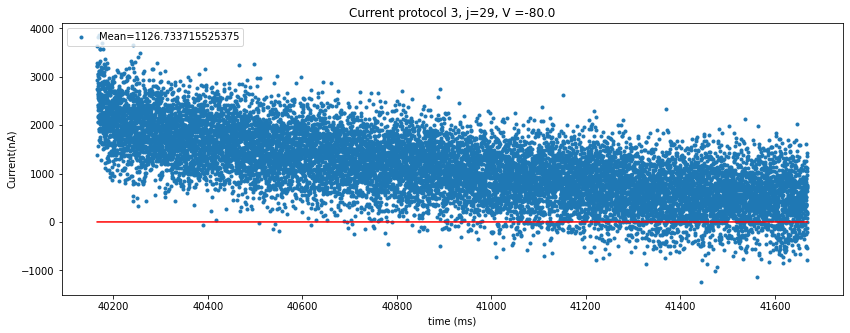

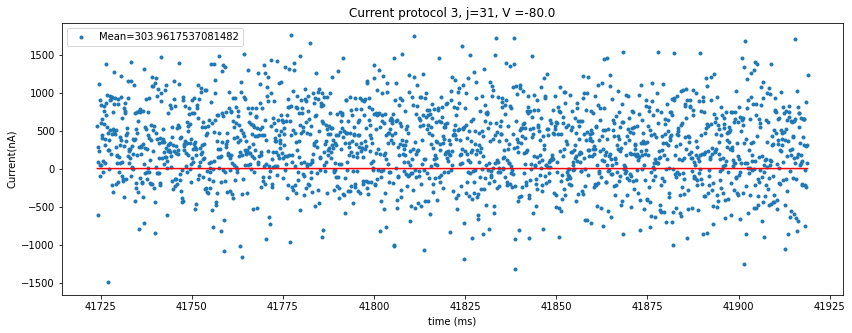

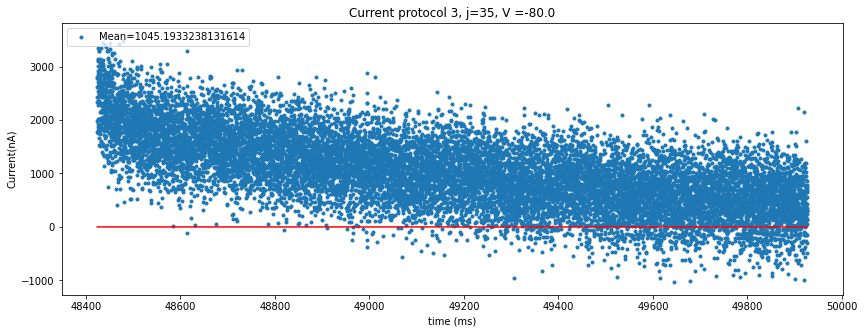

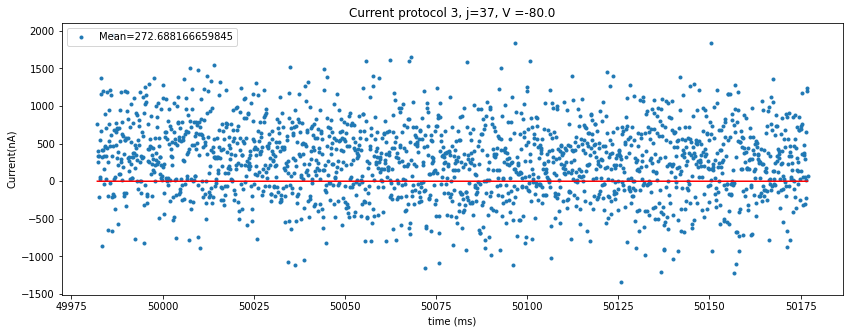

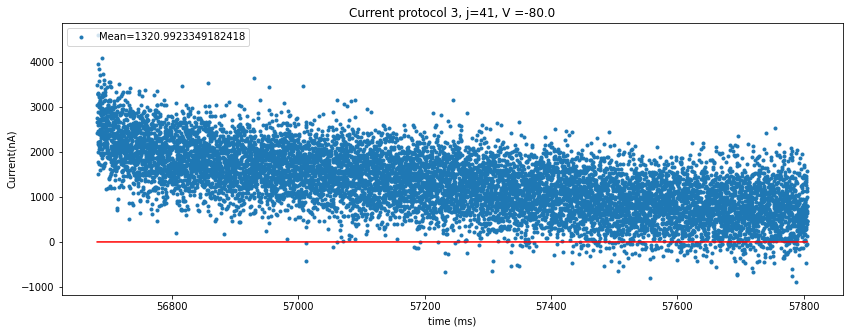

[232632.37181317 235095.23623281 245983.77330536 232434.14084965
 257103.06485859 249275.76625745 280554.88829369 260629.88179407
 431473.74763821 239897.84227216 484740.19979686 253049.74540701
 461857.19757965 240525.27356642 473867.11090556]
305274.68270471133
249213.64042559813
270254.89002763137
249213.64042559813
[-12.611991365112823, 257103.06485859278]
1755.1802601262357


In [125]:
# epsilon for Open

V80_open_means = np.zeros(len(index_neg80))
V80_open_vars = np.zeros(len(index_neg80))
pr3_open_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_open_means[k] = np.mean(pr3_current_constV_without_first5ms[j]/indv_current[j])
    V80_open_vars[k] = np.var(pr3_current_constV_without_first5ms[j]/indv_current[j])
    if np.abs(V80_means[k]) < 0.009:
        pr3_open_constV_80smeanzero =np.append(pr3_open_constV_80smeanzero, pr3_current_constV_without_first5ms[j]/indv_current[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j]/indv_current[j],'.', color = pr3_voltage_constV_colors[j], label='Mean='+str(V80_open_means[k]))
    plt.plot(pr3_time_constV_without_first5ms[j],np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


print(V80_open_vars)
print(np.mean(V80_open_vars))
print(np.mean(V80_open_vars[V80_means<0.002]))
print(np.var(pr3_open_constV_80smeanzero))
print(epsilonB/indv_current[0]**2)
print([V80_open_means[4],V80_open_vars[4]])


x= np.mean(np.reshape(pr3_current_constV[0][:-290]/indv_current[0],[-1, batch_size]),axis=1)
print(np.var(x))

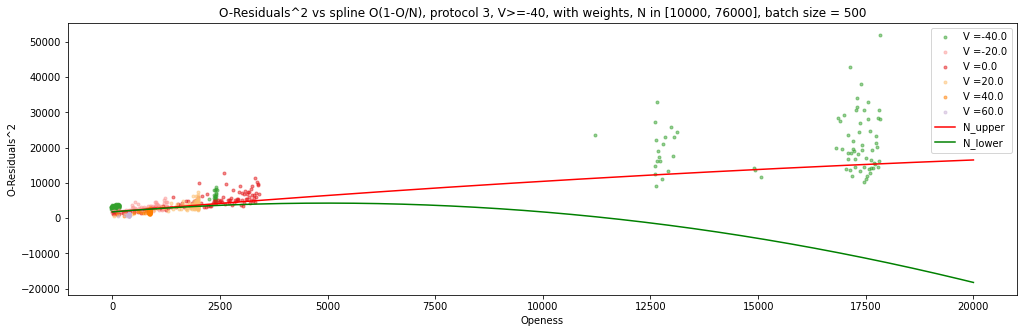

2.492136404255981
[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05]


In [127]:
# Open-R^2 versus O(1-O/N)

open_linspace = np.linspace(0,20000,20000)

plt.figure(figsize=(17, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr3_voltage_constV_colors[i],alpha = 0.5, label=pr3_voltage_constV_labels_simple[i])  
plt.plot(open_linspace, np.var(x) + open_linspace * (1 - open_linspace/N_upper),'-r', label='N_upper')
plt.plot(open_linspace, np.var(x) + open_linspace * (1 - open_linspace/N_lower),'-g', label='N_lower')
plt.ylabel('O-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title('O-Residuals^2 vs spline O(1-O/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) +', batch size = ' + str(batch_size))
plt.xlabel('Openess')
plt.show()
print(epsilonB/(indv_current[0]))
print(indv_current[index_neg80])

## Rest of the protocols

### THE FOLLOWING HAS TO BE RE-EDITED!

In [ ]:
# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()


## My testing code

In [ ]:
tmax = 20
dt = .1
deltat = 100
times = np.arange(0, tmax+dt, dt)
params = np.array([10,.001,100,.01,-100, .001,300])
epsi = 0.0001*np.random.randn(len(times))

three_flag = True

x =  expo_spline(times, deltat, params, three_flag)+ epsi
y = SRexpo_spline(params, times, deltat, x, three_flag)


res = minimize(SRexpo_spline, params,args = (times,deltat, x, three_flag), method='Nelder-Mead', tol=1e-6)

params_res = res.x
z =  expo_spline(times, deltat, params_res, three_flag)


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,z, label = 'Fit')
plt.legend()
plt.show()

print(params_res)
print(params)


In [ ]:
# testing CMA
p0 = params # [0,1,1,.5,1]
es = cma.fmin(SRexpo_spline, params , sigma0=1, args=[times, deltat, x, three_flag])

params_cma = es[0]
score_cma = es[1]


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,expo_spline(times, deltat, params_cma, three_flag), label = 'Fit')
plt.legend()
plt.show()

print(params_cma)
print(score_cma)

In [ ]:
x = np.arange(0, 40, 0.1)
y = np.ones(len(x))
w = 1 / (1 + 9*(x>1) + 90 * (x>10))
print(w)

In [ ]:
index_i = 2
i=index_largerCurrents[index_i]

# Testing definitions
#res = currents_neg30[index_i] - splines_neg30[index_i]
#res2 = res**2
w  = 1 / (1 + 9*((times_neg30[index_i]-deltat_neg30[index_i])>10) + 90*((times_neg30[index_i]-deltat_neg30[index_i])>100) + 900*((times_neg30[index_i]-deltat_neg30[index_i])>1000))



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], res2,'-', label='R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], w*res2,'.', label='w*R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('residuals')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')
plt.show()


p0 = [currents_neg30[index_i][-1], 0.01,times_neg30[index_i][-1]-times_neg30[index_i][0], 0.01,(times_neg30[index_i][-1]-times_neg30[index_i][0]), 0.01, (times_neg30[index_i][-1]-times_neg30[index_i][0])/2, 0.1,1]
bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
    # CMA fit
es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_neg30[index_i], deltat_neg30[index_i], currents_neg30[index_i], NumExpo_flag], options = optscma)
s_neg30_W_test = expo_spline(times_neg30[index_i], deltat_neg30[index_i], es[0], NumExpo_flag)

plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
#plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], s_neg30_W_test, label = 'CMA spline + W')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()